## MIRA LLM equation extraction evaluation

This notebook benchmarks MIRA's LLM equation extraction functionality on a set of 10 compartmental models. The process involves:

**Equation extraction**: We upload an image of a system of equations defining a model to a locally running instance of MIRA’s equation extraction UI. The extracted SymPy equation strings are then pasted into their respective cells in this notebook.

**Initial template model generation**: We attempt to create a MIRA template model directly from the extracted equations. If this fails, we document any modifications needed to make the system of equations valid for MIRA. These edits to the model are done directly in the UI. 

**Correctness evaluation**: After successfully generating a MIRA template model, we assess whether it correctly represents the original compartmental model. Any necessary corrections are noted to ensure veracity are noted. These correction edits are also done directly in the UI.

**Model editing**: To keep track of the step-by-step edits necessary, edits are made directly into the output text box and then the "Generate MIRA Model from ODEs" button is pressed in the "Equation image to MIRA model" page. If the system of ODEs can be converted to an equivalent MIRA template model, then no error will occur. If the ODE string cannot be converted, then an informative error message as to why the ODEs cannot be ingested is displayed. The error is addressed and  "Generate MIRA Model from ODEs" is pressed again. This iterative process keeps repeating until we can create a MIRA template model from the ODE string. 

**Comparing extracted vs. correct models**: If errors in the extracted equations lead to structural differences between the initial model and the correct model, we create MIRA template models for both versions and print out their model structures for comparison purposes. We also group correctness edits into smaller ones that don't affect model structure and structural ones that do affect the dynamics of the model. 



The equation extraction process isn't deterministic and different ODE strings can be generated from the same image of ODE equations.

In [149]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import (
    execute_template_model_from_sympy_odes,
    image_file_to_odes_str,
)
from IPython.display import Image
from collections import defaultdict


client = OpenAIClient()

In [150]:
# BIOMODEL 955

# Executes straight out the box.

# Smaller correction edits
# 1. Defines two lambda parameters - Parameter duplication


original_ode_str_biomd_955 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, I, D, A, R, T, H, E = sympy.symbols("S I D A R T H E", cls=sympy.Function)

# Define the parameters
alpha, beta, gamma, delta, epsilon, zeta, lambda_, eta, rho, theta, mu, nu, xi, sigma, tau, kappa, lambda_ = sympy.symbols("alpha beta gamma delta epsilon zeta lambda eta rho theta mu nu xi sigma tau kappa lambda_")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t))),
    sympy.Eq(I(t).diff(t), S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t)) - (epsilon + zeta + lambda_) * I(t)),
    sympy.Eq(D(t).diff(t), epsilon * I(t) - (eta + rho) * D(t)),
    sympy.Eq(A(t).diff(t), zeta * I(t) - (theta + mu + kappa) * A(t)),
    sympy.Eq(R(t).diff(t), eta * D(t) + theta * A(t) - (nu + xi) * R(t)),
    sympy.Eq(T(t).diff(t), mu * A(t) + nu * R(t) - (sigma + tau) * T(t)),
    sympy.Eq(H(t).diff(t), lambda_ * I(t) + rho * D(t) + kappa * A(t) + xi * R(t) + sigma * T(t)),
    sympy.Eq(E(t).diff(t), tau * T(t))
]
"""


correct_ode_str_biomd_955 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, I, D, A, R, T, H, E = sympy.symbols("S I D A R T H E", cls=sympy.Function)

# Define the parameters
alpha, beta, gamma, delta, epsilon, zeta, lambda_, eta, rho, theta, mu, nu, xi, sigma, tau, kappa = sympy.symbols("alpha beta gamma delta epsilon zeta lambda eta rho theta mu nu xi sigma tau kappa")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t))),
    sympy.Eq(I(t).diff(t), S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t)) - (epsilon + zeta + lambda_) * I(t)),
    sympy.Eq(D(t).diff(t), epsilon * I(t) - (eta + rho) * D(t)),
    sympy.Eq(A(t).diff(t), zeta * I(t) - (theta + mu + kappa) * A(t)),
    sympy.Eq(R(t).diff(t), eta * D(t) + theta * A(t) - (nu + xi) * R(t)),
    sympy.Eq(T(t).diff(t), mu * A(t) + nu * R(t) - (sigma + tau) * T(t)),
    sympy.Eq(H(t).diff(t), lambda_ * I(t) + rho * D(t) + kappa * A(t) + xi * R(t) + sigma * T(t)),
    sympy.Eq(E(t).diff(t), tau * T(t))
]
"""

correct_tm_biomd_955 = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_str_biomd_955, attempt_grounding=False, client=client
)

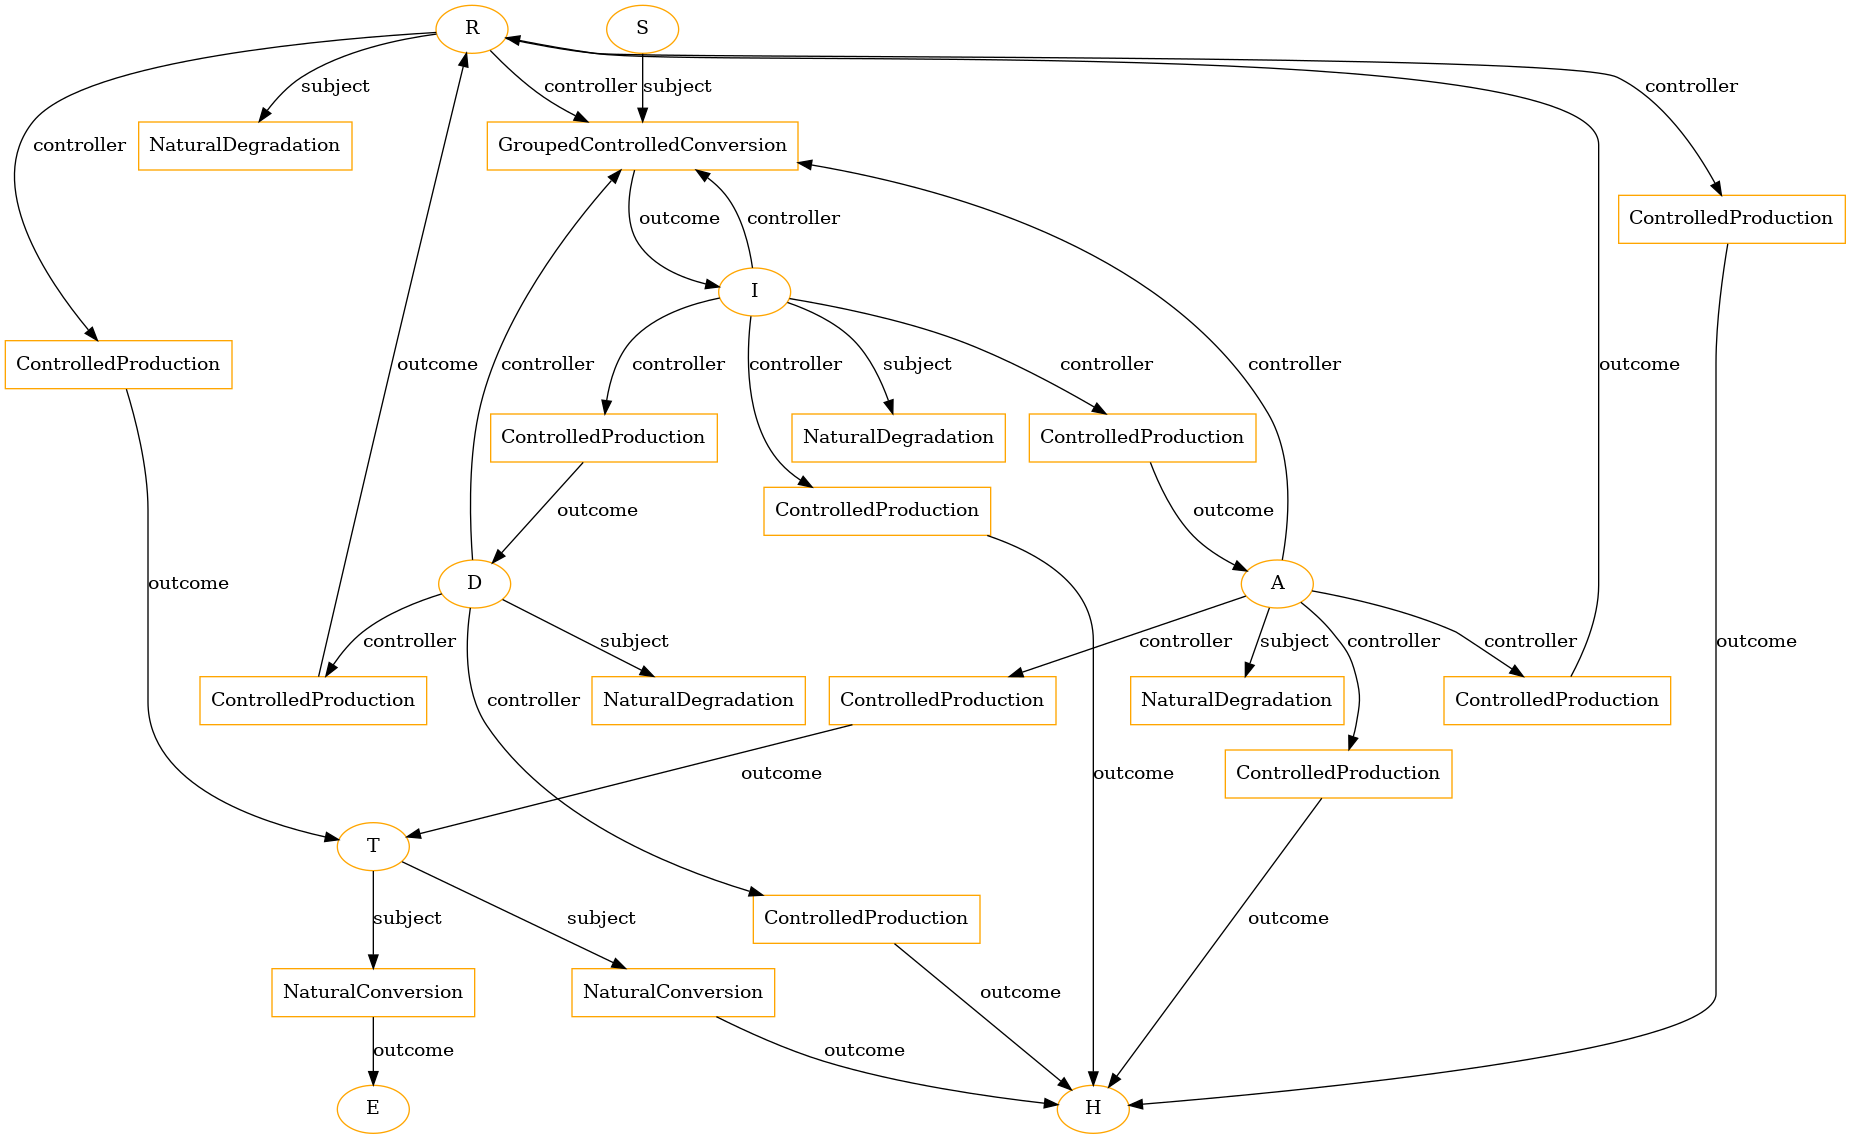

In [151]:
correct_tm_biomd_955.draw_jupyter()

In [152]:
# BIOMODEL 956

# Executes straight out the box

# Structural correction edits
# 1. Conflates the parameter N which represents population as a compartment. Remove N as a compartment and
# add it as a parameter and update the system of equations appropriately. - Parameter-to-compartment conflation

original_ode_str_biomd_956 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, R, N = sympy.symbols("S E I R N", cls=sympy.Function)

# Define the parameters
beta, gamma, alpha = sympy.symbols("beta gamma alpha")

odes = [
    sympy.Eq(S(t).diff(t), - beta * S(t) * I(t) / N(t)),
    sympy.Eq(E(t).diff(t), beta * S(t) * I(t) / N(t) - alpha * E(t)),
    sympy.Eq(I(t).diff(t), alpha * E(t) - gamma * I(t)),
    sympy.Eq(R(t).diff(t), gamma * I(t))
]
"""

error_free_tm_biomd_956 = execute_template_model_from_sympy_odes(
    ode_str=original_ode_str_biomd_956, attempt_grounding=False, client=client
)


correct_ode_str_biomd_956 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, R = sympy.symbols("S E I R", cls=sympy.Function)

# Define the parameters
beta, gamma, alpha, N = sympy.symbols("beta gamma alpha N")

odes = [
    sympy.Eq(S(t).diff(t), - beta * S(t) * I(t) / N),
    sympy.Eq(E(t).diff(t), beta * S(t) * I(t) / N - alpha * E(t)),
    sympy.Eq(I(t).diff(t), alpha * E(t) - gamma * I(t)),
    sympy.Eq(R(t).diff(t), gamma * I(t))
]
"""


correct_tm_biomd_956 = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_str_biomd_956, attempt_grounding=False, client=client
)

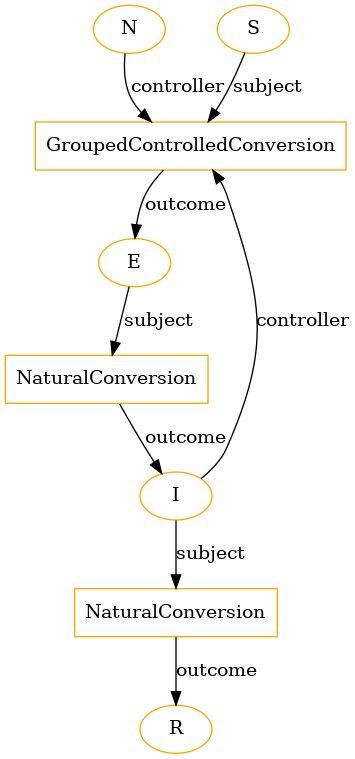

In [153]:
# Error free tm structure
error_free_tm_biomd_956.draw_jupyter()

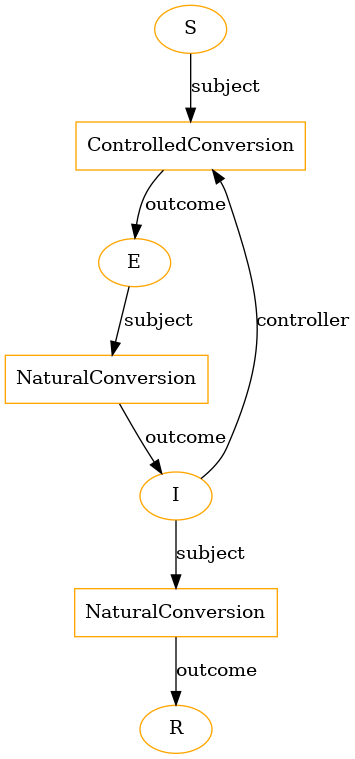

In [154]:
# Correct tm structure
correct_tm_biomd_956.draw_jupyter()

In [155]:
# BIOMODEL 957

# Executes straight out the box.
# No edits are necessary.
# The d parameter isn't defined in the Table 2 of the paper the model is derived from

original_ode_str_957 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, R = sympy.symbols("S E I R", cls=sympy.Function)

# Define the parameters
beta, epsilon, rho, mu, d = sympy.symbols("beta epsilon rho mu d")

odes = [
    sympy.Eq(S(t).diff(t), - beta * S(t) * I(t)),
    sympy.Eq(E(t).diff(t), beta * S(t) * I(t) - epsilon * E(t)),
    sympy.Eq(I(t).diff(t), epsilon * E(t) - (rho + mu) * I(t)),
    sympy.Eq(R(t).diff(t), rho * I(t) - d * R(t))
]
"""

correct_tm_biomd_957 = execute_template_model_from_sympy_odes(
    ode_str=original_ode_str_957, attempt_grounding=False, client=client
)

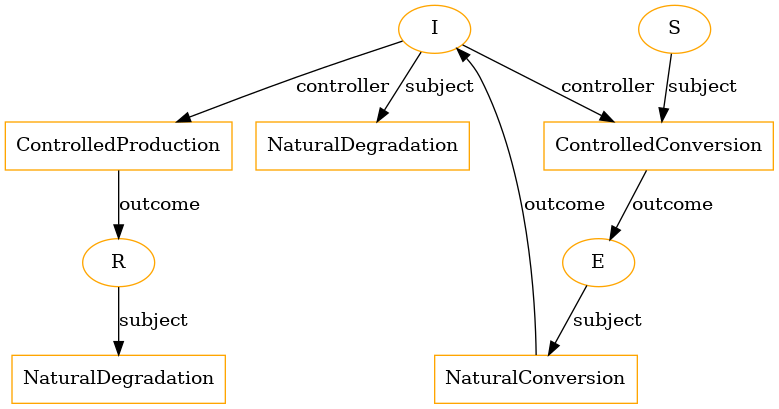

In [156]:
correct_tm_biomd_957.draw_jupyter()

In [157]:
# BIOMODEL 958

# Did not execute straight out the box

# Edits to make it to run
# 1. Missing parameter N (total population) - Undefined parameter
# 2. Conflates kappa parameter with rho when defining parameters, but correctly uses rho in system of equations.
# a. Define rho1 as a parameter - Undefined parameter
# b. Define rho2 as a parameter - Undefined parameter
# 3. Remove erroneous usage of kappa1 and kappa2 parameters in system of equations - Erroneous usage of nonexistent parameter

# Smaller correctness edits
# 1. Compartment P is not divided by N in the equation for compartment S - Missing parameter
# 2. Missing -rho2 term in parenthesis in the equation for compartment A - Missing parameter
# 3. Missing gamma_r as coefficient for H(t) in equation for compartment R - Missing parameter

# Structural correctness edits
# 1. Missing beta_prime * P(t)/N * S(t) term in equation for compartment E - Missing term involving compartment


original_ode_str_958 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, P, A, H, R, F = sympy.symbols("S E I P A H R F", cls=sympy.Function)

# Define the parameters
beta, l, b, beta_prime, kappa1, gamma_alpha, delta_i, kappa2, gamma_i, delta_p, gamma_r, delta_h = sympy.symbols("beta l b beta_prime kappa1 gamma_alpha delta_i kappa2 gamma_i delta_p gamma_r delta_h")

odes = [
    sympy.Eq(S(t).diff(t), -beta * I(t) / N * S(t) - l * beta * H(t) / N * S(t) - beta_prime * P(t) * S(t)),
    sympy.Eq(E(t).diff(t), beta * I(t) / N * S(t) + l * beta * H(t) / N * S(t) - kappa1 * E(t)),
    sympy.Eq(I(t).diff(t), kappa1 * rho1 * E(t) - (gamma_alpha + gamma_i) * I(t) - delta_i * I(t)),
    sympy.Eq(P(t).diff(t), kappa2 * rho2 * E(t) - (gamma_alpha + gamma_i) * P(t) - delta_p * P(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho1) * E(t)),
    sympy.Eq(H(t).diff(t), gamma_alpha * (I(t) + P(t)) - gamma_r * H(t) - delta_h * H(t)),
    sympy.Eq(R(t).diff(t), gamma_i * (I(t) + P(t)) * H(t)),
    sympy.Eq(F(t).diff(t), delta_i * I(t) + delta_p * P(t) + delta_h * H(t))
]
"""

error_free_ode_str_958 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, P, A, H, R, F = sympy.symbols("S E I P A H R F", cls=sympy.Function)

# Define the parameters
N, beta, l, b, beta_prime, kappa, gamma_alpha, delta_i, kappa2, gamma_i, delta_p, gamma_r, delta_h, rho1, rho2  = sympy.symbols("N beta l b beta_prime kappa gamma_alpha delta_i kappa2 gamma_i delta_p gamma_r delta_h rho1 rho2")

odes = [
    sympy.Eq(S(t).diff(t), -beta * I(t) / N * S(t) - l * beta * H(t) / N * S(t) - beta_prime * P(t) * S(t)),
    sympy.Eq(E(t).diff(t), beta * I(t) / N * S(t) + l * beta * H(t) / N * S(t) - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa * rho1 * E(t) - (gamma_alpha + gamma_i) * I(t) - delta_i * I(t)),
    sympy.Eq(P(t).diff(t), kappa * rho2 * E(t) - (gamma_alpha + gamma_i) * P(t) - delta_p * P(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho1) * E(t)),
    sympy.Eq(H(t).diff(t), gamma_alpha * (I(t) + P(t)) - gamma_r * H(t) - delta_h * H(t)),
    sympy.Eq(R(t).diff(t), gamma_i * (I(t) + P(t)) * H(t)),
    sympy.Eq(F(t).diff(t), delta_i * I(t) + delta_p * P(t) + delta_h * H(t))
]
"""
error_free_tm_biomd_958 = execute_template_model_from_sympy_odes(
    ode_str=error_free_ode_str_958, attempt_grounding=False, client=client
)

correct_ode_str_958 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, P, A, H, R, F = sympy.symbols("S E I P A H R F", cls=sympy.Function)

# Define the parameters
N, beta, l, b, beta_prime, kappa, gamma_alpha, delta_i, gamma_i, delta_p, gamma_r, delta_h, rho1, rho2 = sympy.symbols("N beta l b beta_prime kappa gamma_alpha delta_i gamma_i delta_p gamma_r delta_h rho1 rho2")

odes = [
    sympy.Eq(S(t).diff(t), -beta * I(t) / N * S(t) - l * beta * H(t) / N * S(t) - beta_prime * P(t) / N * S(t)),
    sympy.Eq(E(t).diff(t), beta * I(t) / N * S(t) + l * beta * H(t) / N * S(t) + beta_prime * P(t)/N * S(t) - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa * rho1 * E(t) - (gamma_alpha + gamma_i) * I(t) - delta_i * I(t)),
    sympy.Eq(P(t).diff(t), kappa * rho2 * E(t) - (gamma_alpha + gamma_i) * P(t) - delta_p * P(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho1 - rho2) * E(t)),
    sympy.Eq(H(t).diff(t), gamma_alpha * (I(t) + P(t)) - gamma_r * H(t) - delta_h * H(t)),
    sympy.Eq(R(t).diff(t), gamma_i * (I(t) + P(t)) + gamma_r * H(t)),
    sympy.Eq(F(t).diff(t), delta_i * I(t) + delta_p * P(t) + delta_h * H(t))
]
"""


correct_tm_biomd_958 = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_str_958, attempt_grounding=False, client=client
)

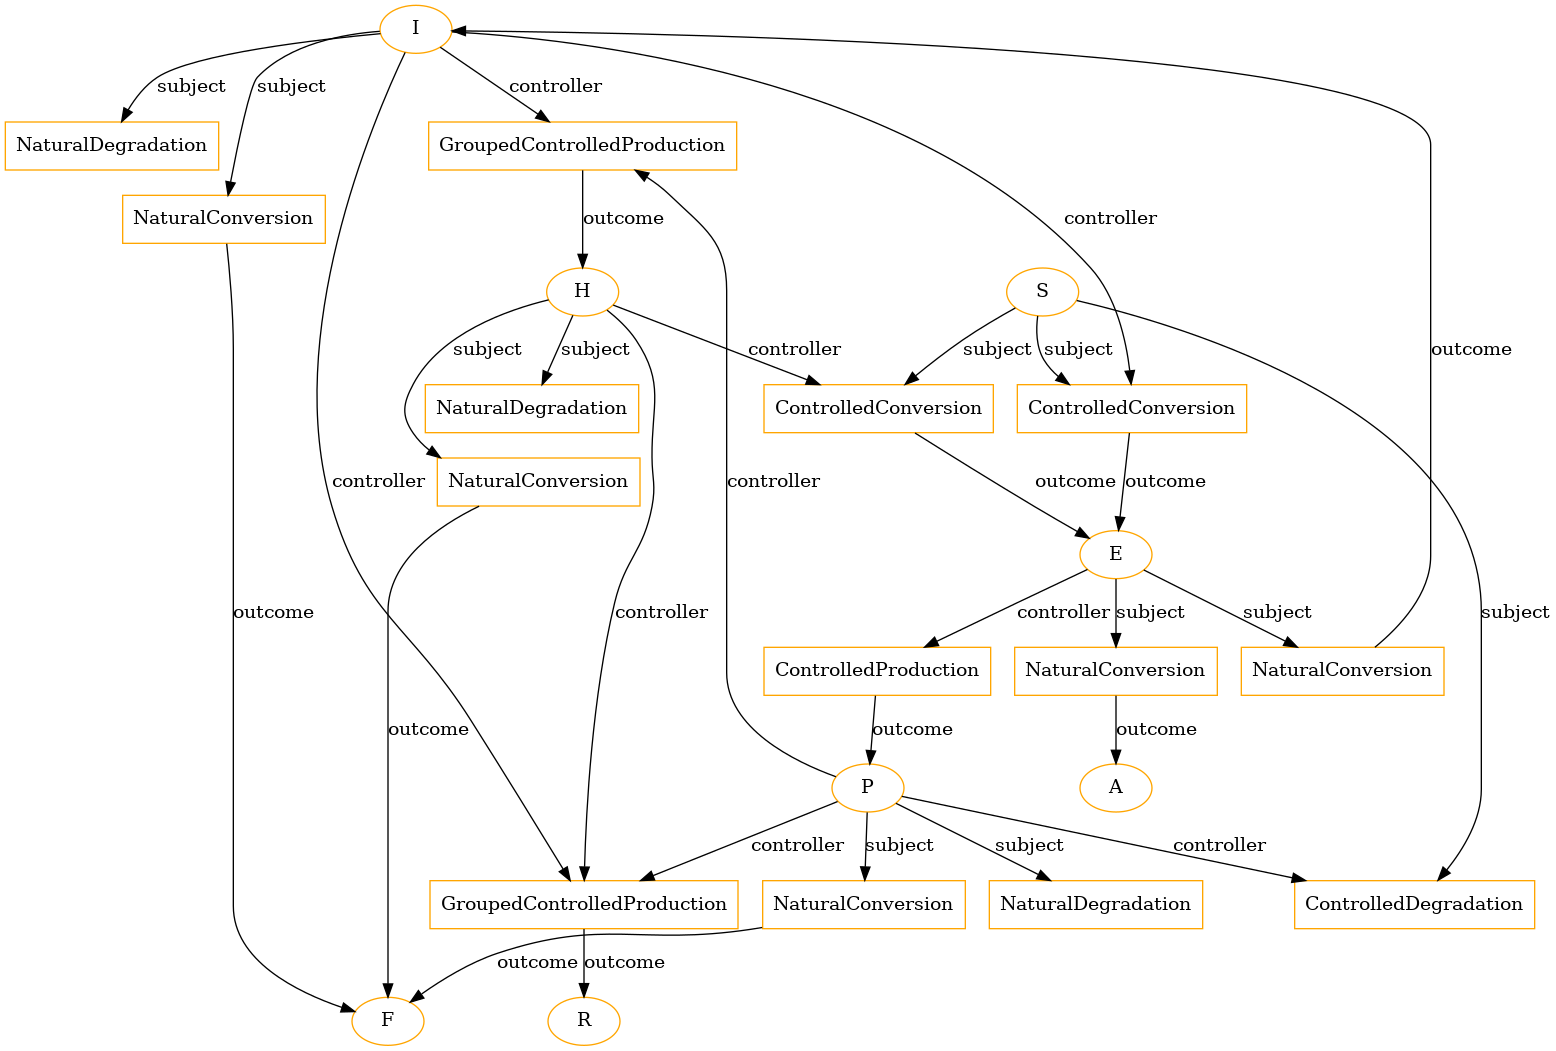

In [158]:
# Error-free tm structure
error_free_tm_biomd_958.draw_jupyter()

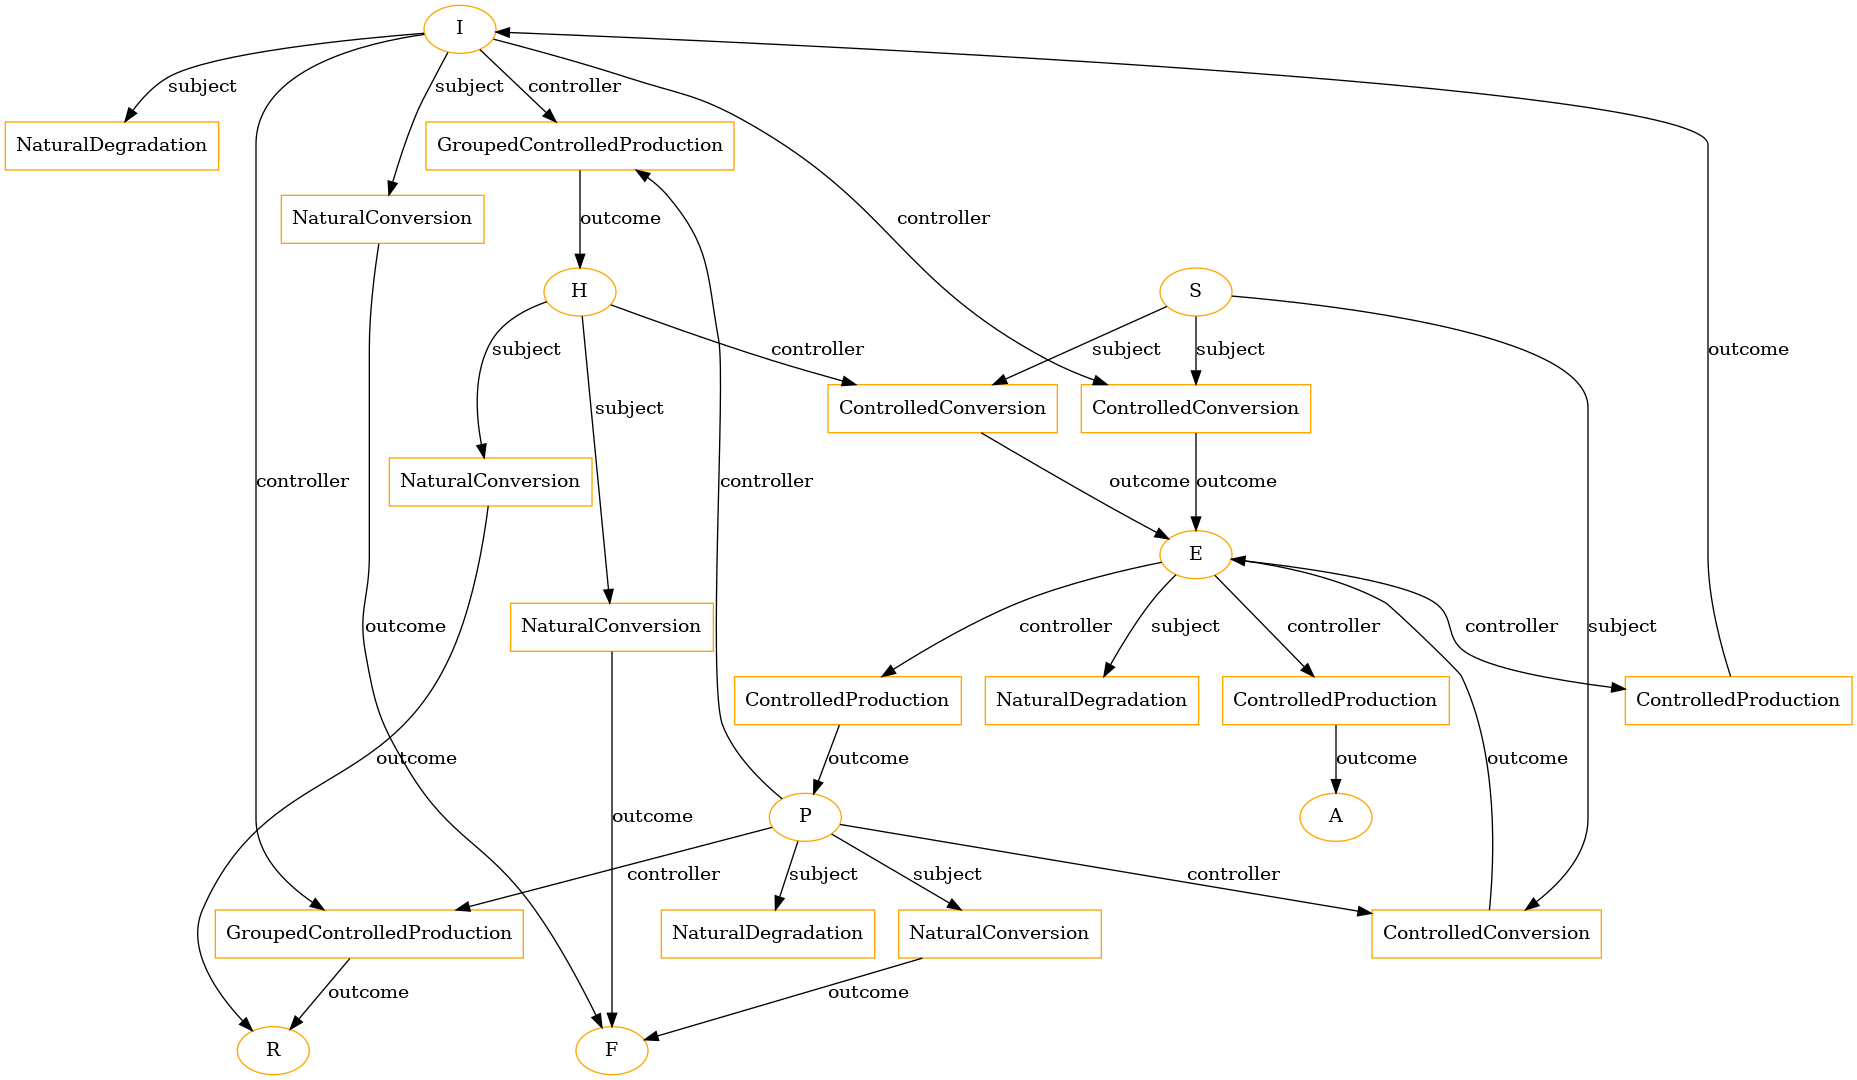

In [159]:
# Correct tm structure
correct_tm_biomd_958.draw_jupyter()

In [160]:
# BIOMODEL 960

# Did not execute straight out the box

# Edits to make it run
# 1. Does not define gamma_r parameter used in system of equations - Undefined parameter
# 2. Uses undefined gamma_H parameter in system of equations - - Erroneous usage of nonexistent parameter
# 3. Does not define delta_A parameter used in system of equations - Undefined parameter


# Smaller correctness edits
# 1. Does not use l, l_a parameters used in the equation for compartment S. Incorrectly replaces them with kappa and delta_I respectively.
#    a. Replace l with kappa - Parameter conflation
#    b. Replace l_a with delta_I - Parameter conflation
# 2. Does not use l, l_a parameters used in equation for compartment E. Incorrectly replaces them with kappa and delta_I respectively.
#    a. Replace l with kappa - Parameter conflation
#    b. Replace l_a with delta_I - Parameter conflation
# 3. Incorrectly defines an extra parameter "mu_A" and uses it when "mu"
#    should be used in equation for compartment A. - Parameter conflation
# 4. Incorrectly defines an extra parameter "mu_A" and uses it when "mu" should be used in
#    equation for compartment D. - Parameter conflation
# 5. Missing delta_A multiplier for mu*A(t) term in equation for compartment D. - Missing parameter


original_ode_str_960 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, A, H, R, D = sympy.symbols("S E I A H R D", cls=sympy.Function)

# Define the parameters
beta, kappa, gamma_a, gamma_I, delta_H, delta_I, mu_A, mu, rho, N = sympy.symbols("beta kappa gamma_a gamma_I delta_H delta_I mu_A mu rho N")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * beta * (I(t) + kappa * A(t) + delta_I * H(t)) / N),
    sympy.Eq(E(t).diff(t), S(t) * beta * (I(t) + kappa * A(t) + delta_I * H(t)) / N - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa * rho * E(t) - (gamma_a + gamma_I + delta_I) * I(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho) * E(t) - mu_A * A(t)),
    sympy.Eq(H(t).diff(t), gamma_a * I(t) - (gamma_r + delta_H) * H(t)),
    sympy.Eq(R(t).diff(t), gamma_I * I(t) + gamma_H * H(t) + mu * (1 - delta_A) * A(t)),
    sympy.Eq(D(t).diff(t), delta_H * H(t) + delta_I * I(t) + mu_A * A(t))
]
"""

correct_ode_str_960 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, A, H, R, D = sympy.symbols("S E I A H R D", cls=sympy.Function)

# Define the parameters
l, l_a, beta, kappa, gamma_a, gamma_I, gamma_r, delta_H, delta_I, delta_A, mu_A, mu, rho, N = sympy.symbols("l l_a beta kappa gamma_a gamma_I gamma_r delta_H delta_I delta_A mu_A mu rho N")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * beta * (I(t) + l_a * A(t) + l * H(t)) / N),
    sympy.Eq(E(t).diff(t), S(t) * beta * (I(t) + l_a * A(t) + l * H(t)) / N - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa * rho * E(t) - (gamma_a + gamma_I + delta_I) * I(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho) * E(t) - mu * A(t)),
    sympy.Eq(H(t).diff(t), gamma_a * I(t) - (gamma_r + delta_H) * H(t)),
    sympy.Eq(R(t).diff(t), gamma_I * I(t) + gamma_r * H(t) + mu * (1 - delta_A) * A(t)),
    sympy.Eq(D(t).diff(t), delta_H * H(t) + delta_I * I(t) + mu * delta_A * A(t))
]
"""

correct_tm_biomd_960 = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_str_960, attempt_grounding=False, client=client
)

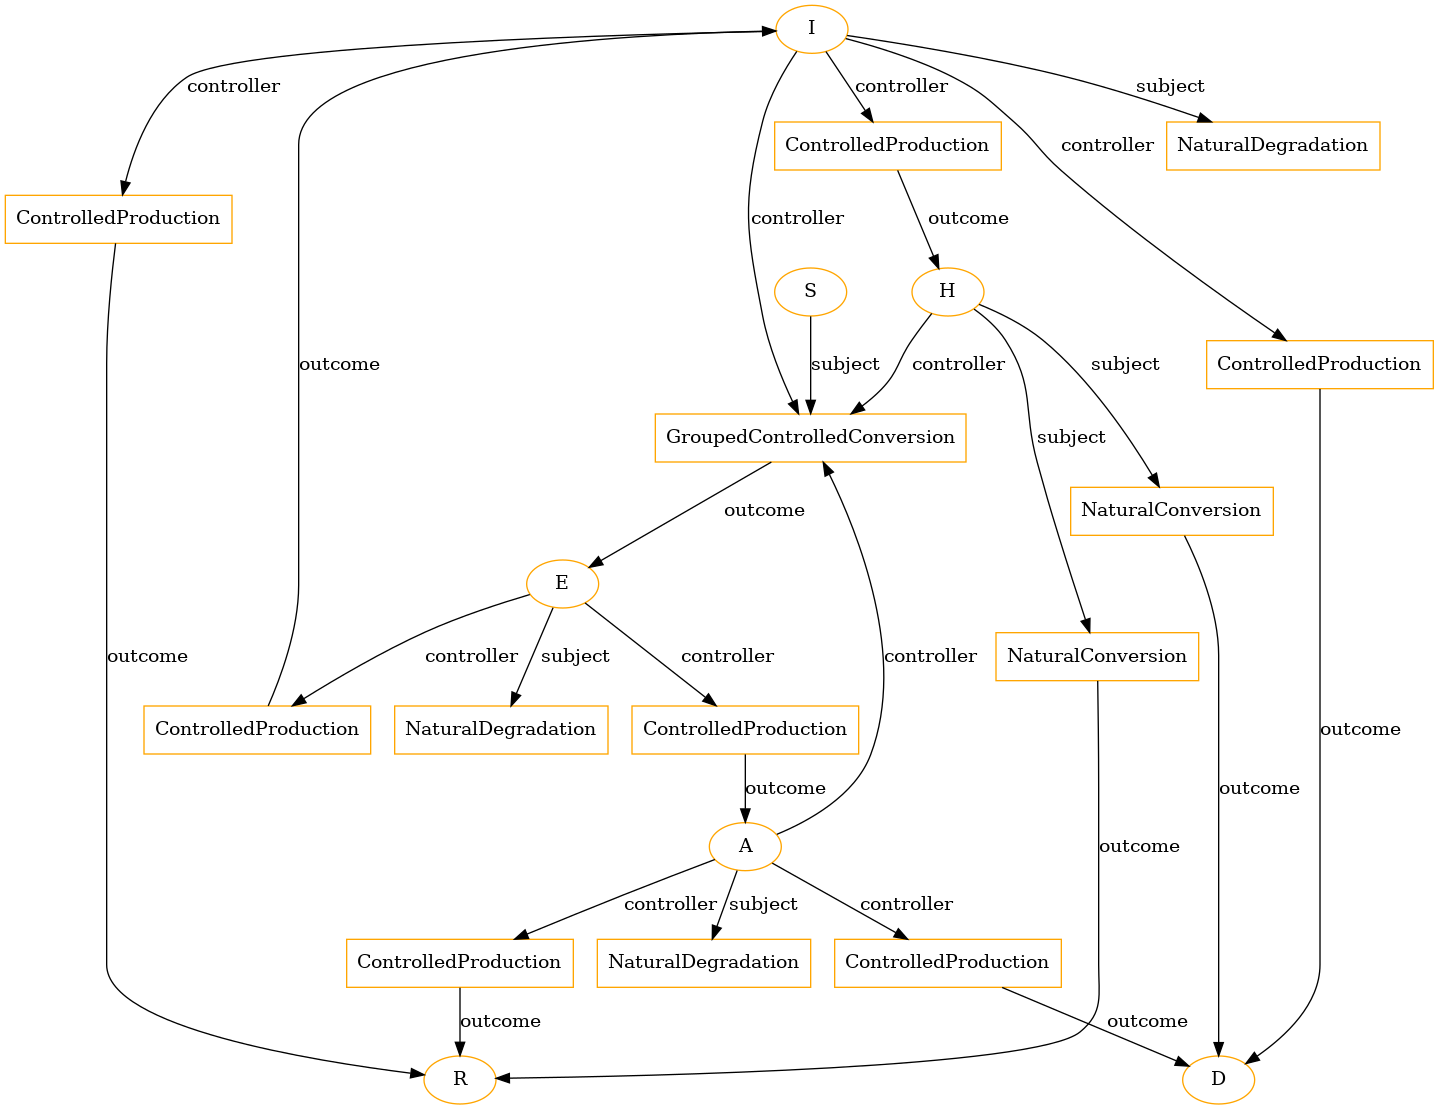

In [161]:
correct_tm_biomd_960.draw_jupyter()

In [162]:
# BIOMODEL 962

# Executes straight out the box

# Structural correctness edits
# 1. Define compartments U and S as functions of time in equation for compartment U - Time-dependence error


original_ode_str_biomd_962 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, U, Q, C = sympy.symbols("S U Q C", cls=sympy.Function)

# Define the parameters
a, N, gamma1, gamma2, sigma = sympy.symbols("a N gamma1 gamma2 sigma")

odes = [
    sympy.Eq(S(t).diff(t), -a * U(t) * S(t) / N),
    sympy.Eq(U(t).diff(t), a * U(0) * S(0) / N - gamma1 * U(t)),
    sympy.Eq(Q(t).diff(t), gamma1 * U(t) - (gamma2 + (1 - gamma2) * sigma) * Q(t)),
    sympy.Eq(C(t).diff(t), (gamma2 + (1 - gamma2) * sigma) * Q(t))
]
"""

error_free_tm_biomd_962 = execute_template_model_from_sympy_odes(
    ode_str=original_ode_str_biomd_962, attempt_grounding=False, client=client
)

correct_ode_str_biomd_962 = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, U, Q, C = sympy.symbols("S U Q C", cls=sympy.Function)

# Define the parameters
a, N, gamma1, gamma2, sigma = sympy.symbols("a N gamma1 gamma2 sigma")

odes = [
    sympy.Eq(S(t).diff(t), -a * U(t) * S(t) / N),
    sympy.Eq(U(t).diff(t), a * U(t) * S(t) / N - gamma1 * U(t)),
    sympy.Eq(Q(t).diff(t), gamma1 * U(t) - (gamma2 + (1 - gamma2) * sigma) * Q(t)),
    sympy.Eq(C(t).diff(t), (gamma2 + (1 - gamma2) * sigma) * Q(t))
]
"""


correct_tm_biomd_962 = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_str_biomd_962, attempt_grounding=False, client=client
)

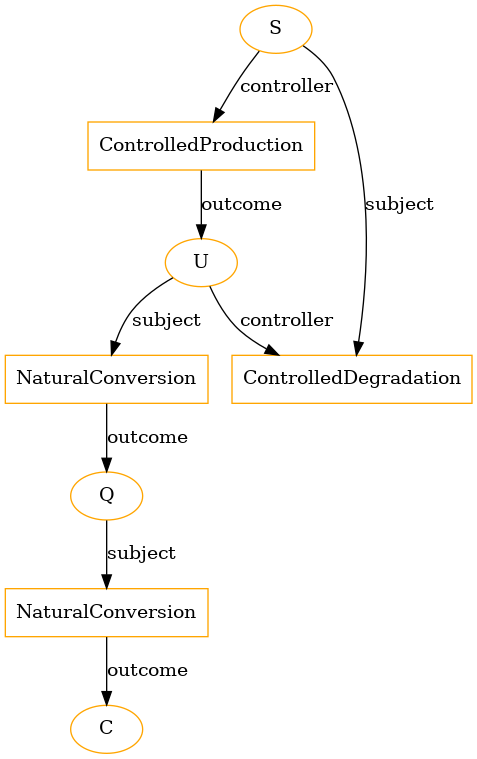

In [163]:
# error-free tm structure
error_free_tm_biomd_962.draw_jupyter()

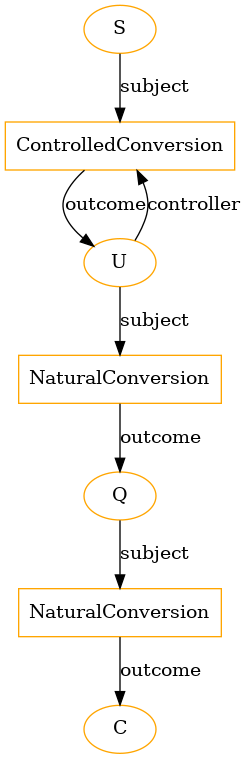

In [164]:
# correct tm structure
correct_tm_biomd_962.draw_jupyter()

In [165]:
# December 2024 Hackathon Epi Scenario 1 Model A


# Does not run execute straight out the box

# Edits to make it run
# 1. Does not define theta1 parameter used in equation for compartment I_2 - Undefined parameter
# 2. Does not define lambda_f parameter used in equations for compartments S_f and E_f - Undefined parameter
# 3. Does not define mu_f parameter used in equation for compartments S_f, E_f, I_f, and R_f - Undefined parameter
# 4. Does not define sigma_f parameter used in equation for compartments E_f and I_f - Undefined parameter
# 5. Does not define delta_f parameter used in equation for compartment I_f - Undefined parameter
# 6. Does not define tau_f parameter used in equation for comparments I_f and R_f - Undefined parameter
# 7. Does not define sigma_r used in equation for compartment I_r - Undefined parameter
# 8. Confuses "r" for "f" in some subscripts for compartment and parameter names. Uses e_r(t) correctly in equation for compartment I_r,
# but defines e_r as e_f when defining time-dependent variables. Uses e_f(t) incorrectly instead of e_r(t) in equation for compartments
# E_f and I_f. Rename e_f to e_r in left-hand side for definition of e_f(t). - Inconsistent compartment naming
# 9. Does not define delta_r parameter used in equation for compartment I_r - Undefined parameter
# 10. Does not define mu_r parameter used in equation for compartments I_r and R_r - Undefined parameter
# 11. Does not define tau_r parameter used in equation for compartment R_r - Undefined parameter

# Smaller correctness edits
# 1. Multiplies first term by "pi" instead of "pi_h". Remove "pi" and add "pi_h" as parameter. - Parameter conflation
# 2. Uses incorrect "v" parameter instead of "nu" parameter in equation for compartment E_h. "v" and the symbol for "nu" look alike.
#    Remove unused parameter "v". - Parameter conflation
# 3. Uses "k2" and "tau2" parameters instead of "theta" and "mu_h" parameters in summation
#    in parenthesis in equation for compartment I_1.
#    a. Replace "k2" with "theta" - Parameter conflation
#    b. Replace "tau2" with "mu_h" - Parameter conflation
# 4. Incorrectly labels "theta" as "theta1". Rename "theta1" to "theta". - Parameter conflation
# 5. Does not add "mu_h" in summation in parenthesis that's apart of the second term in equation compartment I_2. - Missing parameter
# 6. Incorrectly labels "delta" as "delta_i" parameter in summation in parenthesis that's apart of the
#    second term in equation for compartment I_2. - Parameter conflation
# 7. Rename "delta" to "delta_i". - Parameter conflation
# 8. Missing tau3 and delta_h parameters that have to be added to mu_h term in equation for compartment H.
#    a. Add tau3 - Missing parameter
#    b. Add delta_h - Missing parameter
# 9. Rename "delta_f" to "delta_h" as LLM confuses subscript r with f sometimes for compartment and parameter names. - Parameter conflation
# 10. Uses "pi" instead of "pi_r" parameter in equation for compartment S_f. Have to define pi_r parameter. - Parameter conflation
# 11. Uses "lambda_f*s_f(t) - mu_f*s_f(t)" instead of "lambda_r*s_r(t) - mu_r*s_r(t)" in equation for compartment S_f.
#     a. Replace lambda_f definition with lambda_r. - Parameter conflation
#     b. Replace s_f time-dependent variable definition with s_r. - Incorrect compartment naming
# 12. Uses "sigma_f" and "mu_f" instead of "sigma_r" and "mu_r" in equation for compartment E_r.
#     a. Replace "sigma_f" with "sigma_r" - Parameter conflation
#     b. Replace "mu_f" with "mu_r" - Parameter conflation
# 13. Add "tau_r" parameter missing in summation in parenthesis in equation for compartment I_r. - Missing parameter

# Structural correctness edits
# 1. Does not multiply first theta term by "i1(t)" in equation for compartment I_2. - Missing term involving compartment
# 2. Does not subtract first term from second term in equation for compartment I_2. - Incorrect system dynamics
# 3. Incorrectly multiplies first and second term instead of adding them in equation for compartment H. - Incorrect system dynamics
# 4. Missing "tau3*h(t)" term to be added in equation for compartment R_h. - Missing term involving compartment
# 5. Incorrectly multiplies "tau2" parameter by "h(t)" instead of "i2(t)" in equation for compartment R_h. - Incorrect system dynamics
# 6. Remove two additional equation definitions for non-existent compartments I_f and R_f. - Removal of invalid equations
# 7. Missing "- mu_h * s_h(t)" term in equation for compartment S_h. Missing term involving compartment
# 8. Incorrectly multiplies first term by "s_h(t)" in equation for compartment S_h. - Incorrect system dynamics


original_ode_string_2024_dec_epi_1_model_A = """
Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
s1, s_h, e_h, p, i1, i2, h, r_h, s_f, e_f, i_f, r_f, e_r, i_r, r_r = sympy.symbols("s1 s_h e_h p i1 i2 h r_h s_f e_f i_f r_f e_r i_r r_r", cls=sympy.Function)

# Define the parameters
pi, rho, nu, mu_h, lambda_h, v, omega, k1, k2, k3, tau1, tau2, tau3, delta, sigma = sympy.symbols("pi rho nu mu_h lambda_h v omega k1 k2 k3 tau1 tau2 tau3 delta sigma")

odes = [
    sympy.Eq(s1(t).diff(t), pi * (1 - rho) - nu * lambda_h * s1(t) - mu_h * s1(t)),
    sympy.Eq(s_h(t).diff(t), mu_h * rho * s_h(t) - lambda_h * s_h(t)),
    sympy.Eq(e_h(t).diff(t), (v * s1(t) + s_h(t)) * lambda_h - (sigma + mu_h) * e_h(t)),
    sympy.Eq(p(t).diff(t), sigma * e_h(t) - (omega + mu_h) * p(t)),
    sympy.Eq(i1(t).diff(t), omega * p(t) - (k1 + k2 + tau1 + tau2) * i1(t)),
    sympy.Eq(i2(t).diff(t), theta1 * (k2 + delta + tau2) * i2(t)),
    sympy.Eq(h(t).diff(t), k1 * i1(t) * k2 * i2(t) - mu_h * h(t)),
    sympy.Eq(r_h(t).diff(t), tau1 * i1(t) + tau2 * h(t) - mu_h * r_h(t)),
    sympy.Eq(s_f(t).diff(t), pi - lambda_f * s_f(t) - mu_f * s_f(t)),
    sympy.Eq(e_f(t).diff(t), lambda_f * s_f(t) - (sigma_f + mu_f) * e_f(t)),
    sympy.Eq(i_f(t).diff(t), sigma_f * e_f(t) - (delta_f + tau_f + mu_f) * i_f(t)),
    sympy.Eq(r_f(t).diff(t), tau_f * i_f(t) - mu_f * r_f(t)),
    sympy.Eq(i_r(t).diff(t), sigma_r * e_r(t) - (delta_r + mu_r) * i_r(t)),
    sympy.Eq(r_r(t).diff(t), tau_r * i_r(t) - mu_r * r_r(t))
]
"""

error_free_ode_string_2024_dec_epi_1_model_A = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
s1, s_h, e_h, p, i1, i2, h, r_h, s_f, e_f, i_f, r_f, e_r, i_r, r_r = sympy.symbols("s1 s_h e_h p i1 i2 h r_h s_f e_f i_f r_f e_r i_r r_r", cls=sympy.Function)

# Define the parameters
theta1, lambda_f, mu_f, sigma_f, delta_f, tau_f, sigma_r, delta_r, mu_r, tau_r, pi, rho, nu, mu_h, lambda_h, v, omega, k1, k2, k3, tau1, tau2, tau3, delta, sigma = sympy.symbols("theta1 lambda_f mu_f sigma_f delta_f tau_f sigma_r delta_r mur_r tau_r pi rho nu mu_h lambda_h v omega k1 k2 k3 tau1 tau2 tau3 delta sigma")

odes = [
    sympy.Eq(s1(t).diff(t), pi * (1 - rho) - nu * lambda_h * s1(t) - mu_h * s1(t)),
    sympy.Eq(s_h(t).diff(t), mu_h * rho * s_h(t) - lambda_h * s_h(t)),
    sympy.Eq(e_h(t).diff(t), (v * s1(t) + s_h(t)) * lambda_h - (sigma + mu_h) * e_h(t)),
    sympy.Eq(p(t).diff(t), sigma * e_h(t) - (omega + mu_h) * p(t)),
    sympy.Eq(i1(t).diff(t), omega * p(t) - (k1 + k2 + tau1 + tau2) * i1(t)),
    sympy.Eq(i2(t).diff(t), theta1 * (k2 + delta + tau2) * i2(t)),
    sympy.Eq(h(t).diff(t), k1 * i1(t) * k2 * i2(t) - mu_h * h(t)),
    sympy.Eq(r_h(t).diff(t), tau1 * i1(t) + tau2 * h(t) - mu_h * r_h(t)),
    sympy.Eq(s_f(t).diff(t), pi - lambda_f * s_f(t) - mu_f * s_f(t)),
    sympy.Eq(e_r(t).diff(t), lambda_f * s_f(t) - (sigma_f + mu_f) * e_f(t)),
    sympy.Eq(i_f(t).diff(t), sigma_f * e_f(t) - (delta_f + tau_f + mu_f) * i_f(t)),
    sympy.Eq(r_f(t).diff(t), tau_f * i_f(t) - mu_f * r_f(t)),
    sympy.Eq(i_r(t).diff(t), sigma_r * e_r(t) - (delta_r + mu_r) * i_r(t)),
    sympy.Eq(r_r(t).diff(t), tau_r * i_r(t) - mu_r * r_r(t))
]
"""

error_free_tm_2024_dec_epi1_modelA = execute_template_model_from_sympy_odes(
    ode_str=error_free_ode_string_2024_dec_epi_1_model_A,
    attempt_grounding=False,
    client=client,
)

correct_ode_string_2024_dec_epi_1_model_A = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
s1, s_h, e_h, p, i1, i2, h, r_h, s_r, e_r, i_r, r_r = sympy.symbols("s1 s_h e_h p i1 i2 h r_h s_r e_r i_r r_r", cls=sympy.Function)

# Define the parameters
theta, pi_h, pi_r, rho, nu, mu_h, mu_r, lambda_h, lambda_r, omega, k1, k2, k3, tau1, tau2, tau3, tau_f, tau_r, delta_i, delta_h, delta_r, sigma,  sigma_r = sympy.symbols("theta pi_h pi_r rho nu mu_h  mu_r lambda_h lambda_f omega k1 k2 k3 tau1 tau2 tau3 tau_f tau_r delta_i delta_h delta_r sigma  sigma_r")
odes = [
    sympy.Eq(s1(t).diff(t), pi_h * (1 - rho) - nu * lambda_h * s1(t) - mu_h * s1(t)),
    sympy.Eq(s_h(t).diff(t), mu_h * rho - lambda_h * s_h(t) - mu_h * s_h(t)),
    sympy.Eq(e_h(t).diff(t), (nu * s1(t) + s_h(t)) * lambda_h - (sigma + mu_h) * e_h(t)),
    sympy.Eq(p(t).diff(t), sigma * e_h(t) - (omega + mu_h) * p(t)),
    sympy.Eq(i1(t).diff(t), omega * p(t) - (theta + k1 + tau1 + mu_h) * i1(t)),
    sympy.Eq(i2(t).diff(t), theta * i1(t) - (k2 + delta_i + tau2 + mu_h) * i2(t)),
    sympy.Eq(h(t).diff(t), k1 * i1(t) + k2 * i2(t) - (mu_h + tau3 + delta_h) * h(t)),
    sympy.Eq(r_h(t).diff(t), tau1 * i1(t) + tau2 * i2(t) + tau3*h(t) - mu_h * r_h(t)),
    sympy.Eq(s_r(t).diff(t), pi_r - lambda_r * s_r(t) - mu_r * s_r(t)),
    sympy.Eq(e_r(t).diff(t), lambda_r * s_r(t) - (sigma_r + mu_r) * e_r(t)),
    sympy.Eq(i_r(t).diff(t), sigma_r * e_r(t) - (delta_r + mu_r + tau_r) * i_r(t)),
    sympy.Eq(r_r(t).diff(t), tau_r * i_r(t) - mu_r * r_r(t))
]
"""


correct_tm_2024_dec_epi1_modelA = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_string_2024_dec_epi_1_model_A,
    attempt_grounding=False,
    client=client,
)

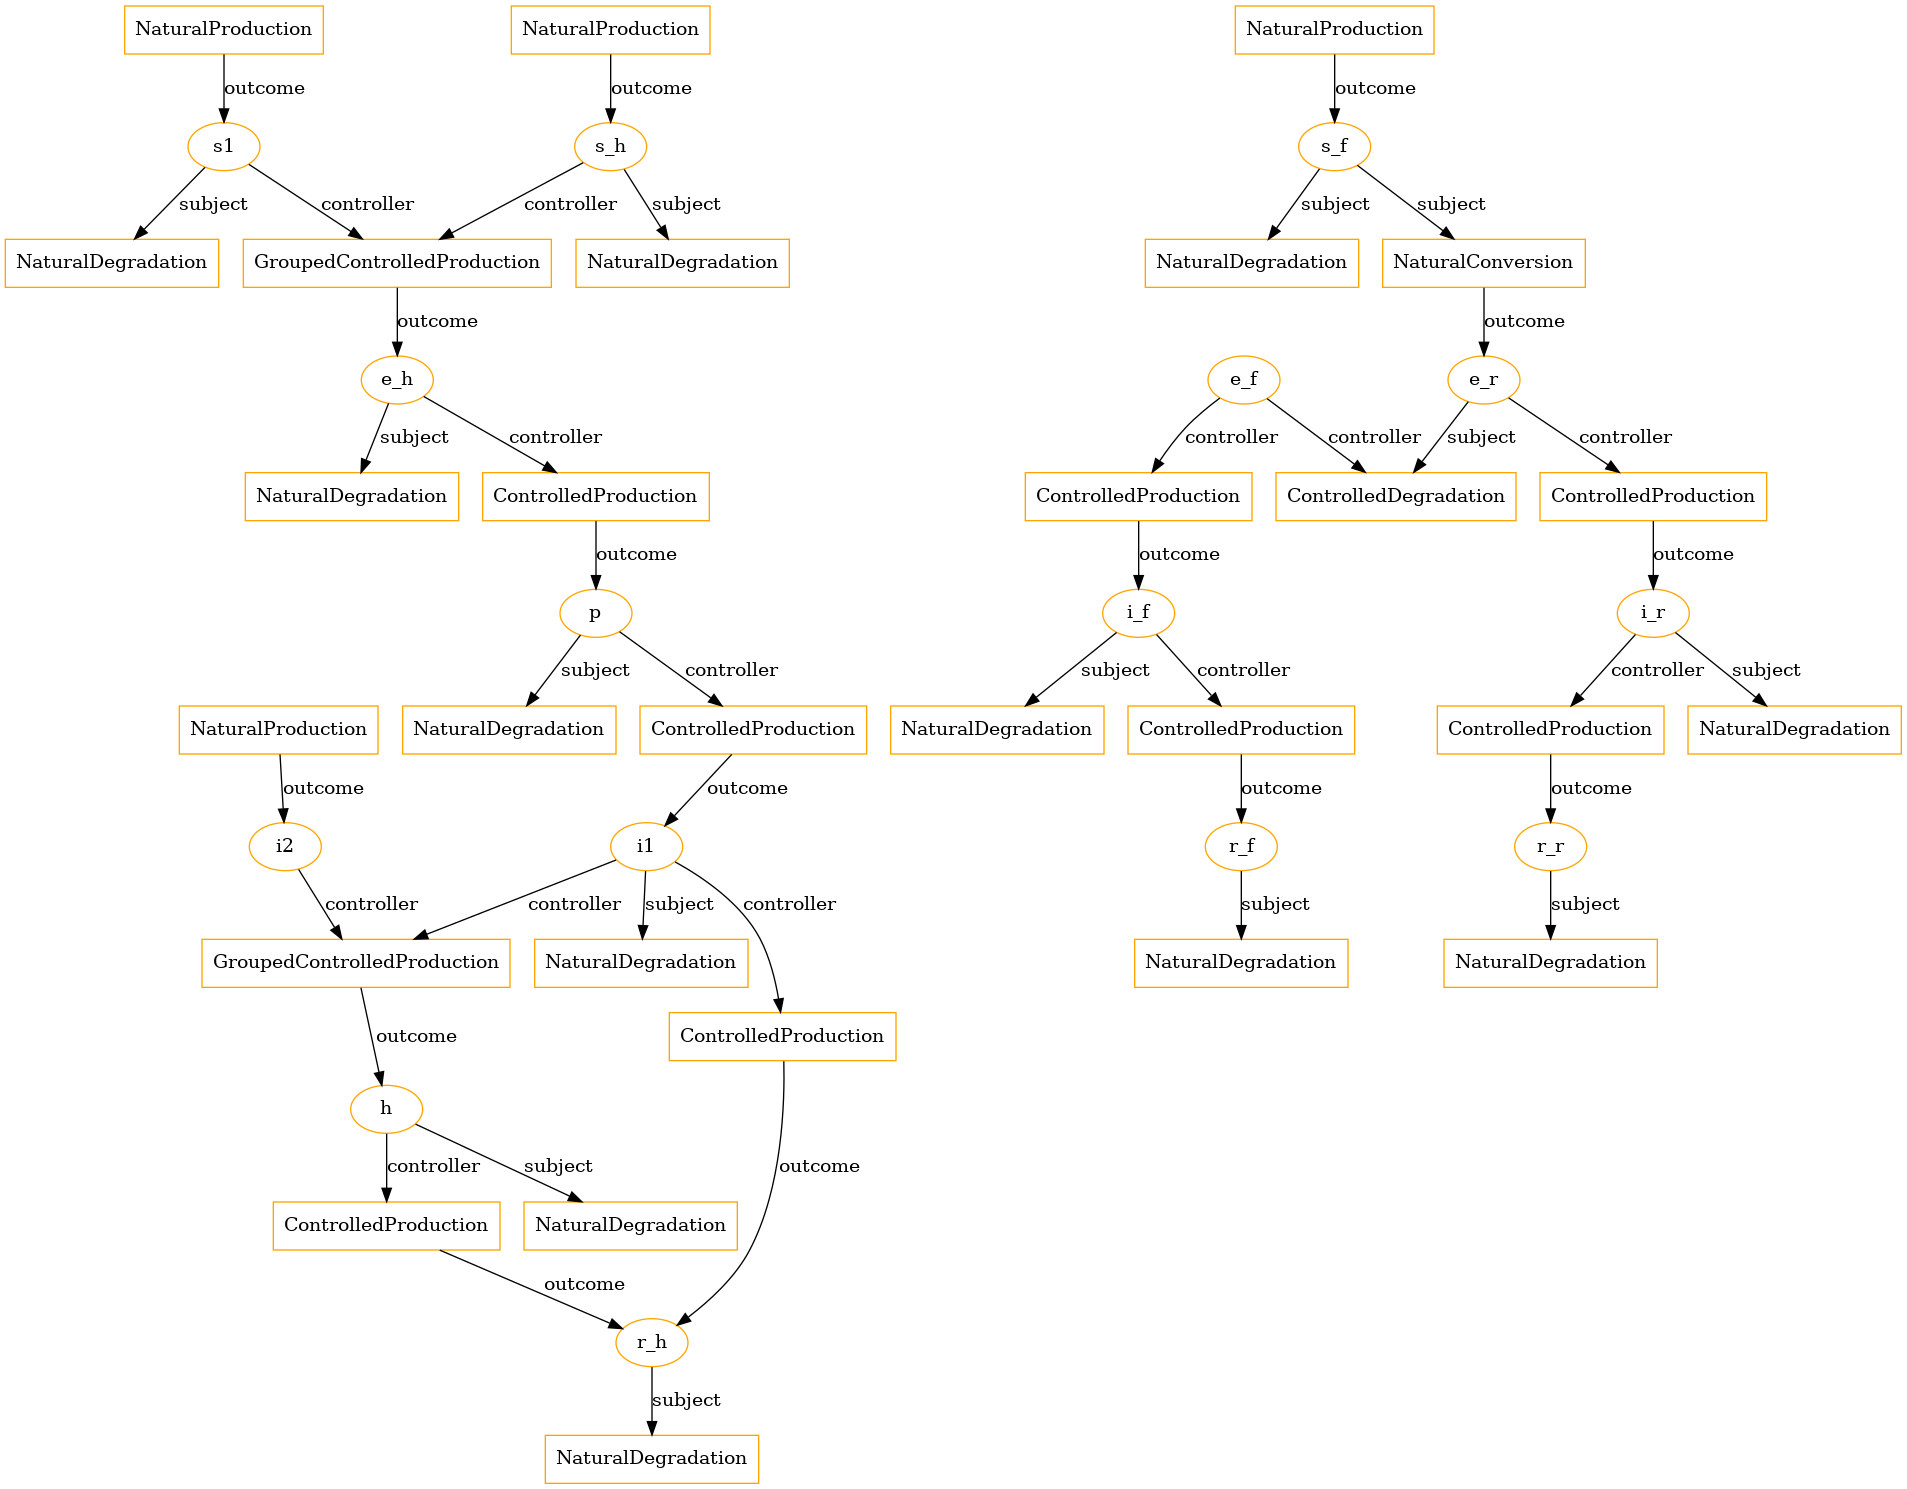

In [166]:
# Error-free tm structure
error_free_tm_2024_dec_epi1_modelA.draw_jupyter()

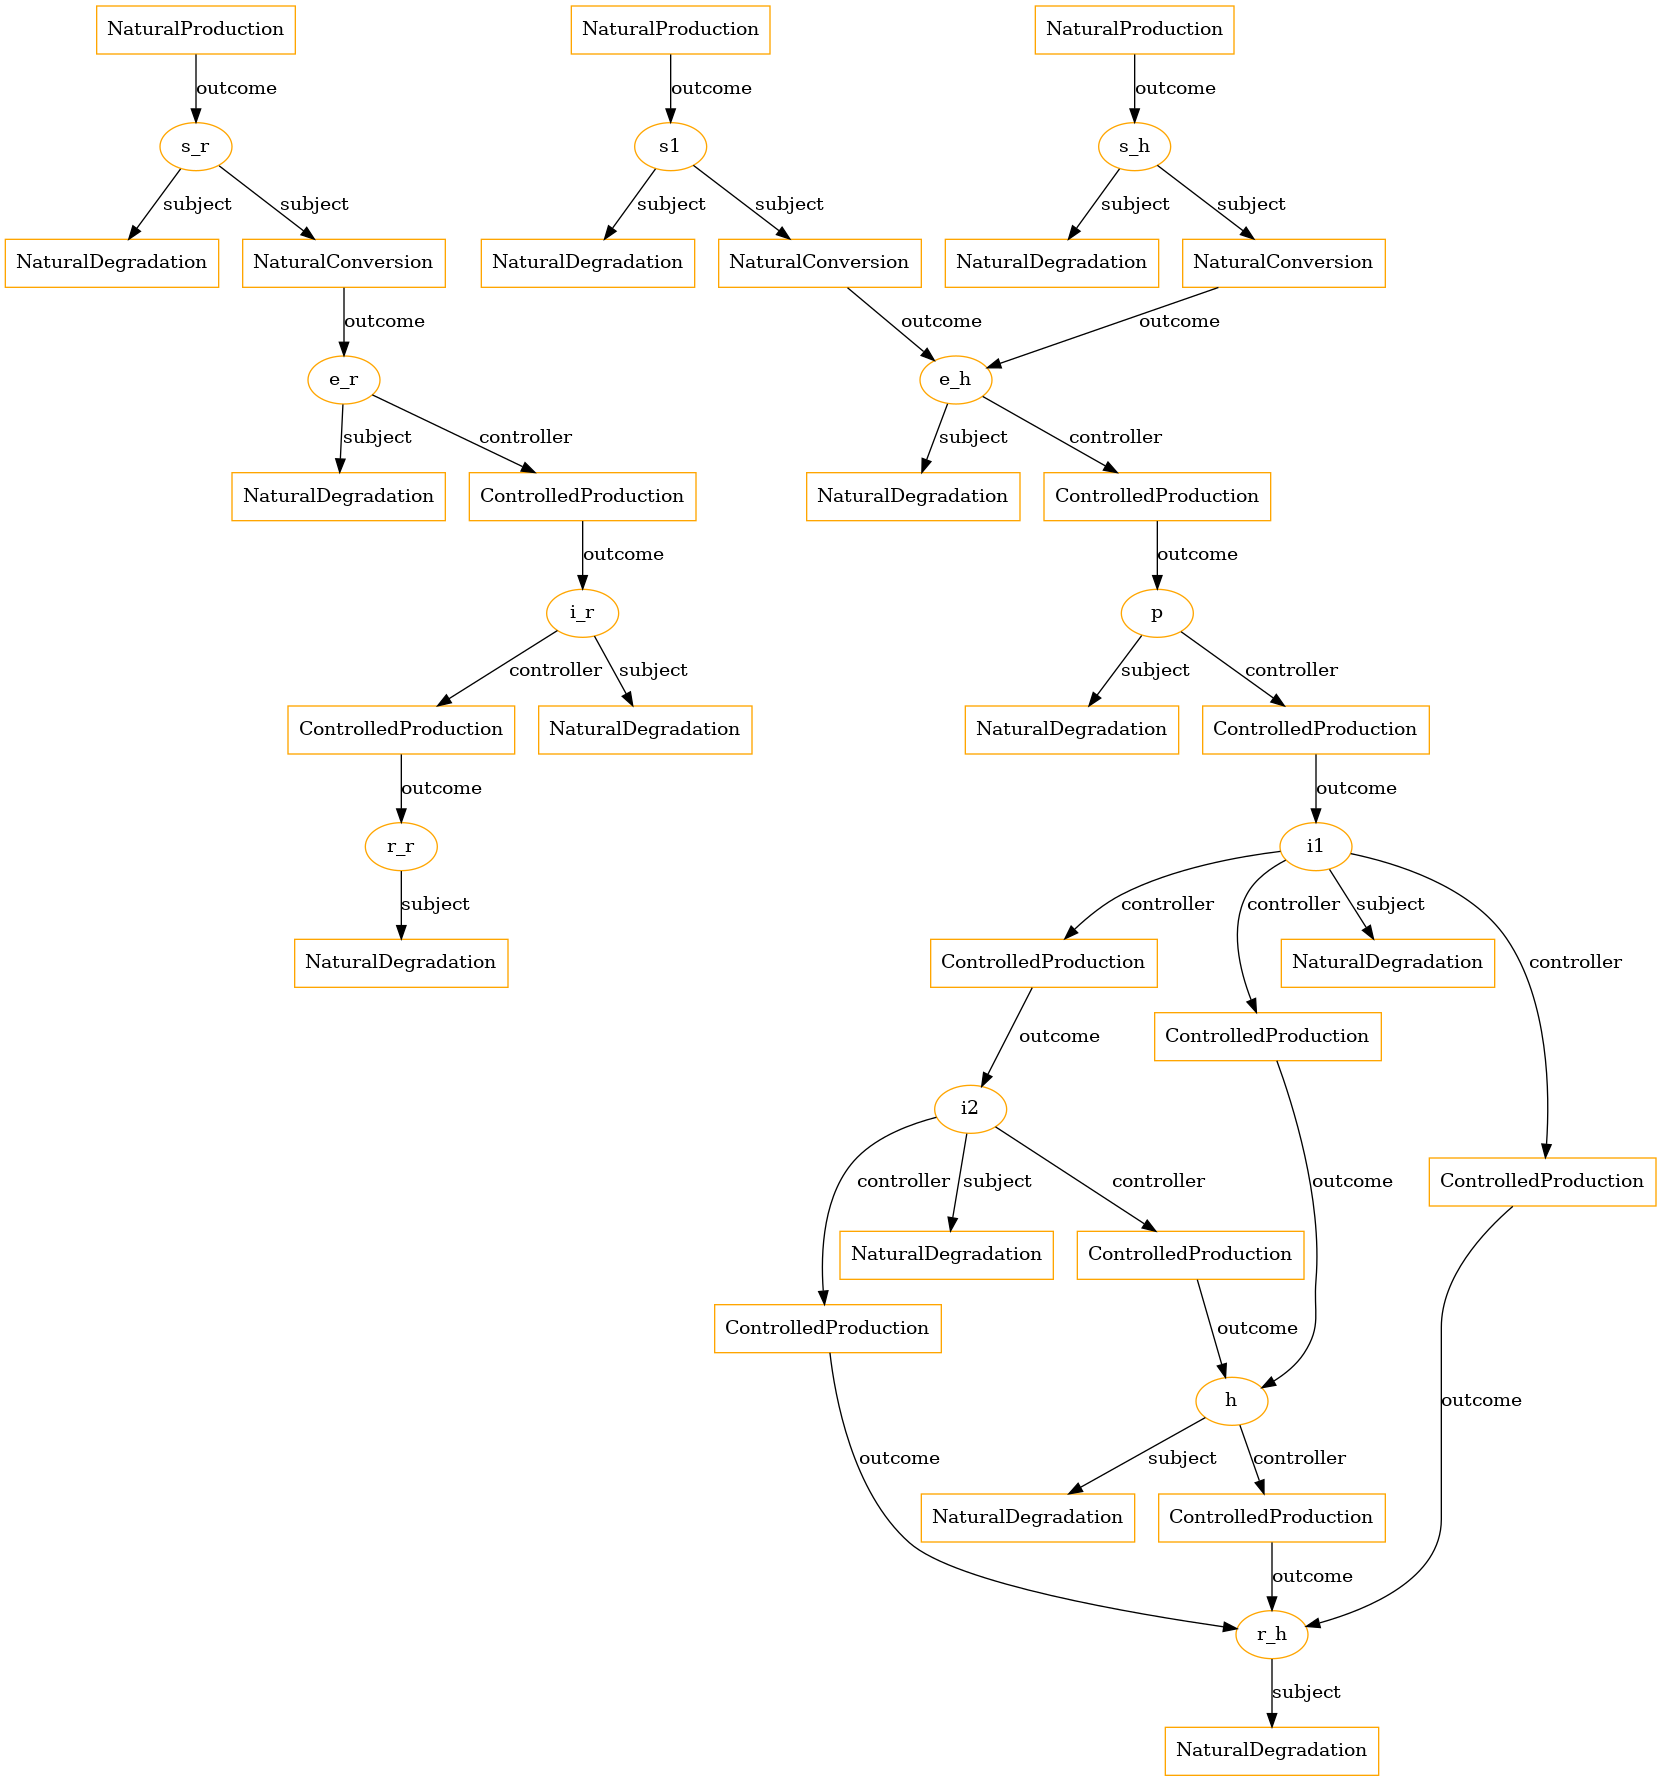

In [167]:
# Correct tm structure
correct_tm_2024_dec_epi1_modelA.draw_jupyter()

In [168]:
# December 2024 Hackathon Epi Scenario 1 Model B

# Did not execute straight out the box

# Edits to make it run
# 1. Does not define tau parameter used in compartment Q_h - Undefined parameter
# 2. Missing i_r time-dependent variable definition - Missing compartment definition

# Smaller correctness edits
# 1. Multiplies "beta_1" by "ih(t)" instead of "ir(t)" in equation for compartment S_h.
#    Due to "h" and "r" subscript conflation by LLM. - Parameter conflation
# 2. Missing beta_h term in equation for compartment S_h. Define beta_h as a parameter. - Missing parameter
# 3. Multiplies "beta_1" by "ih(t)" instead of "ir(t)" in equation for compartment E_h.
#    Due to "h" and "r" subscript conflation by LLM. - Parameter conflation
# 4. Missing initial "beta_r" term in equation for compartment S_r. Define beta_r as a parameter. - Missing parameter
# 5. Replace "beta_s" term with "beta_3" term in equation for compartment S_r. Define beta_3 as a parameter. - Parameter conflation
# 6. Replace "beta_s" term with "beta_3" in equation for compartment E_r. - Parameter conflation
# 7. Replace "mu_t" term with "mu_r" in equation for compartment E_r.  - Parameter conflation
# 8. Replace "mu_t" term with "mu_r" in equation for compartment I_r.  - Parameter conflation
# 9. Replace "delta_h" term with "delta_r" in equation for compartment I_r. Define delta_r as a parameter. - Parameter conflation

# Structural correctness edits
# 1. Missing "tau*qh(t)" term that's added to "gamma * qh(t)" in equation for compartment R_h - Missing term involving compartment
# 2. Add "-mu_r*sr(t)" term to equation for compartment S_r. Define mu_r as a parameter - Missing term involving compartment


original_ode_string_2024_dec_epi_1_model_B = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
sh, eh, ih, qh, rh, sr, er = sympy.symbols("sh eh ih qh rh sr er", cls=sympy.Function)

# Define the parameters
beta_1, beta_2, mu_h, phi, N_h, alpha_1, alpha_2, gamma, beta_s, N_r, mu_t, delta_h, alpha_3 = sympy.symbols("beta_1 beta_2 mu_h phi N_h alpha_1 alpha_2 gamma beta_s N_r mu_t delta_h alpha_3")

odes = [
    sympy.Eq(sh(t).diff(t), (beta_1 * ih(t) + beta_2 * ih(t)) * sh(t) / N_h - mu_h * sh(t) + phi * qh(t)),
    sympy.Eq(eh(t).diff(t), (beta_1 * ih(t) + beta_2 * ih(t)) * sh(t) / N_h - (alpha_1 + alpha_2 + mu_h) * eh(t)),
    sympy.Eq(ih(t).diff(t), alpha_1 * eh(t) - (mu_h + delta_h + gamma) * ih(t)),
    sympy.Eq(qh(t).diff(t), alpha_2 * eh(t) - (phi + tau + delta_h + mu_h) * qh(t)),
    sympy.Eq(rh(t).diff(t), gamma * qh(t) - mu_h * rh(t)),
    sympy.Eq(sr(t).diff(t), - beta_s * sr(t) * ir(t) / N_r),
    sympy.Eq(er(t).diff(t), beta_s * sr(t) * ir(t) / N_r - (mu_t + alpha_3) * er(t)),
    sympy.Eq(ir(t).diff(t), alpha_3 * er(t) - (mu_t + delta_h) * ir(t))
]
"""

error_free_ode_string_2024_dec_epi_1_model_B = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
sh, eh, ih, qh, rh, sr, er, ir = sympy.symbols("sh eh ih qh rh sr er ir", cls=sympy.Function)

# Define the parameters
tau, beta_1, beta_2, mu_h, phi, N_h, alpha_1, alpha_2, gamma, beta_s, N_r, mu_t, delta_h, alpha_3 = sympy.symbols("tau beta_1 beta_2 mu_h phi N_h alpha_1 alpha_2 gamma beta_s N_r mu_t delta_h alpha_3")

odes = [
    sympy.Eq(sh(t).diff(t), (beta_1 * ih(t) + beta_2 * ih(t)) * sh(t) / N_h - mu_h * sh(t) + phi * qh(t)),
    sympy.Eq(eh(t).diff(t), (beta_1 * ih(t) + beta_2 * ih(t)) * sh(t) / N_h - (alpha_1 + alpha_2 + mu_h) * eh(t)),
    sympy.Eq(ih(t).diff(t), alpha_1 * eh(t) - (mu_h + delta_h + gamma) * ih(t)),
    sympy.Eq(qh(t).diff(t), alpha_2 * eh(t) - (phi + tau + delta_h + mu_h) * qh(t)),
    sympy.Eq(rh(t).diff(t), gamma * qh(t) - mu_h * rh(t)),
    sympy.Eq(sr(t).diff(t), - beta_s * sr(t) * ir(t) / N_r),
    sympy.Eq(er(t).diff(t), beta_s * sr(t) * ir(t) / N_r - (mu_t + alpha_3) * er(t)),
    sympy.Eq(ir(t).diff(t), alpha_3 * er(t) - (mu_t + delta_h) * ir(t))
]
"""


error_free_tm_2024_dec_epi1_modelB = execute_template_model_from_sympy_odes(
    ode_str=error_free_ode_string_2024_dec_epi_1_model_B,
    attempt_grounding=False,
    client=client,
)


correct_ode_string_2024_dec_epi_1_model_B = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
sh, eh, ih, qh, rh, sr, er, ir = sympy.symbols("sh eh ih qh rh sr er ir", cls=sympy.Function)

# Define the parameters
tau, beta_1, beta_2, beta_3, beta_h, beta_r, mu_h, phi, N_h, alpha_1, alpha_2, gamma, beta_s, N_r, mu_t, mu_r, delta_h, delta_r, alpha_3 = sympy.symbols("tau beta_1 beta_2 beta_3 beta_h beta_r mu_h phi N_h alpha_1 alpha_2 gamma beta_s N_r mu_t mu_r delta_h delta_r alpha_3")

odes = [
    sympy.Eq(sh(t).diff(t), beta_h - (beta_1 * ir(t) + beta_2 * ih(t)) * sh(t) / N_h - mu_h * sh(t) + phi * qh(t)),
    sympy.Eq(eh(t).diff(t), (beta_1 * ir(t) + beta_2 * ih(t)) * sh(t) / N_h - (alpha_1 + alpha_2 + mu_h) * eh(t)),
    sympy.Eq(ih(t).diff(t), alpha_1 * eh(t) - (mu_h + delta_h + gamma) * ih(t)),
    sympy.Eq(qh(t).diff(t), alpha_2 * eh(t) - (phi + tau + delta_h + mu_h) * qh(t)),
    sympy.Eq(rh(t).diff(t), gamma * qh(t) + tau*qh(t) - mu_h * rh(t)),
    
    sympy.Eq(sr(t).diff(t), beta_r - (beta_3 * sr(t) * ir(t) / N_r) - mu_r*sr(t)),
    
    sympy.Eq(er(t).diff(t), beta_3 * sr(t) * ir(t) / N_r - (mu_r + alpha_3) * er(t)),
    sympy.Eq(ir(t).diff(t), alpha_3 * er(t) - (mu_r + delta_r) * ir(t))
]
"""

correct_tm_2024_dec_epi1_modelB = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_string_2024_dec_epi_1_model_B,
    attempt_grounding=False,
    client=client,
)

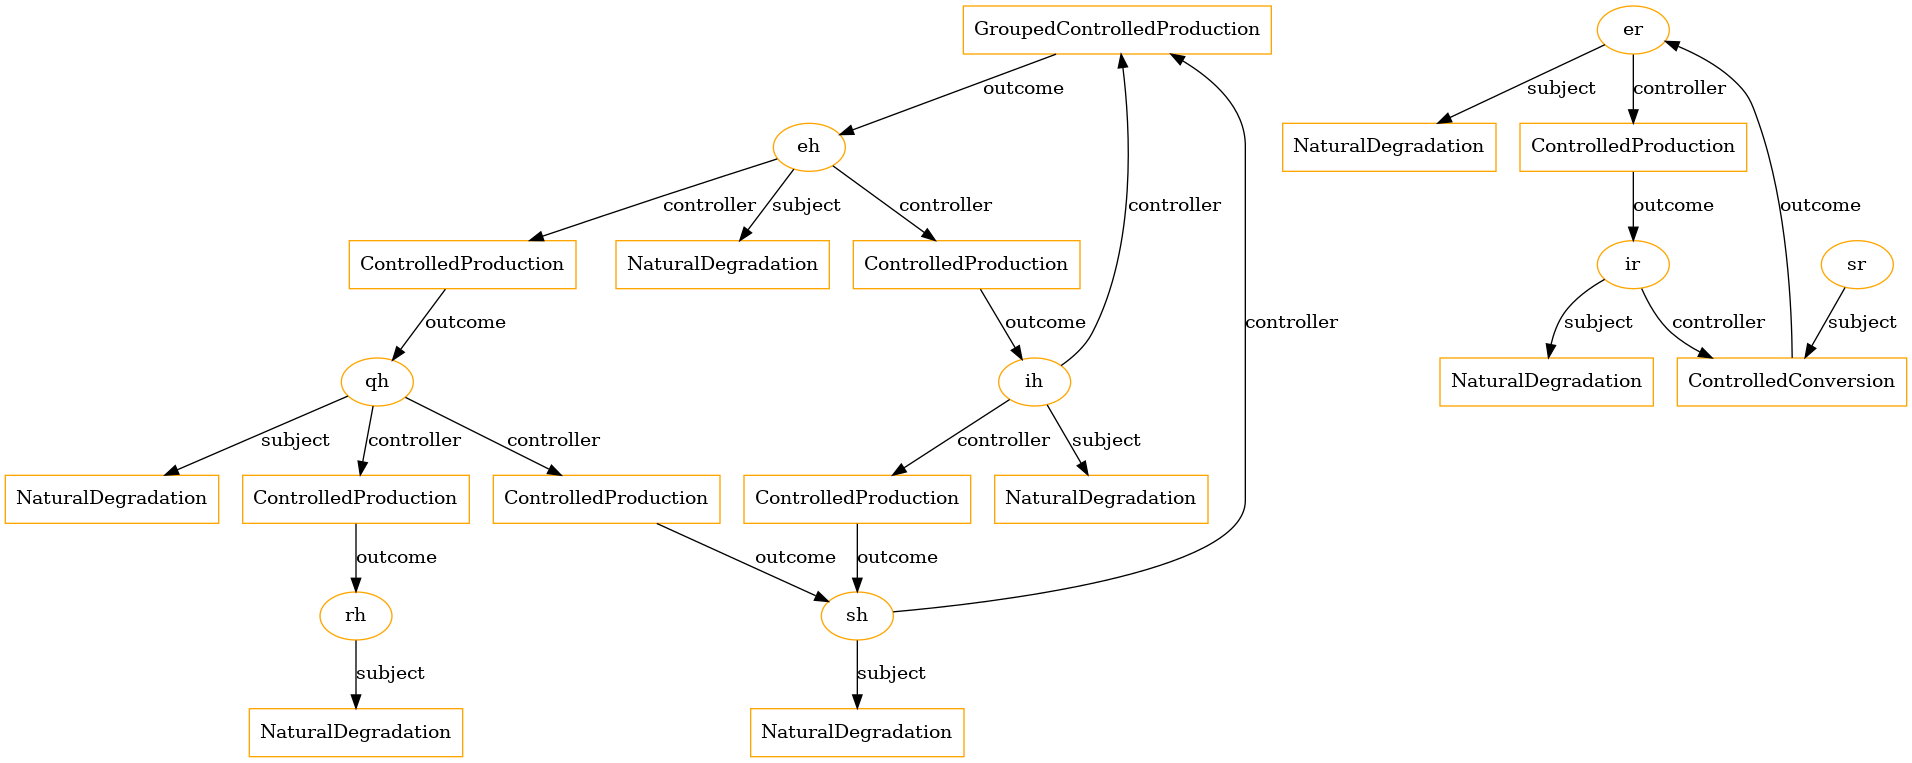

In [169]:
# Error-free tm structure
error_free_tm_2024_dec_epi1_modelB.draw_jupyter()

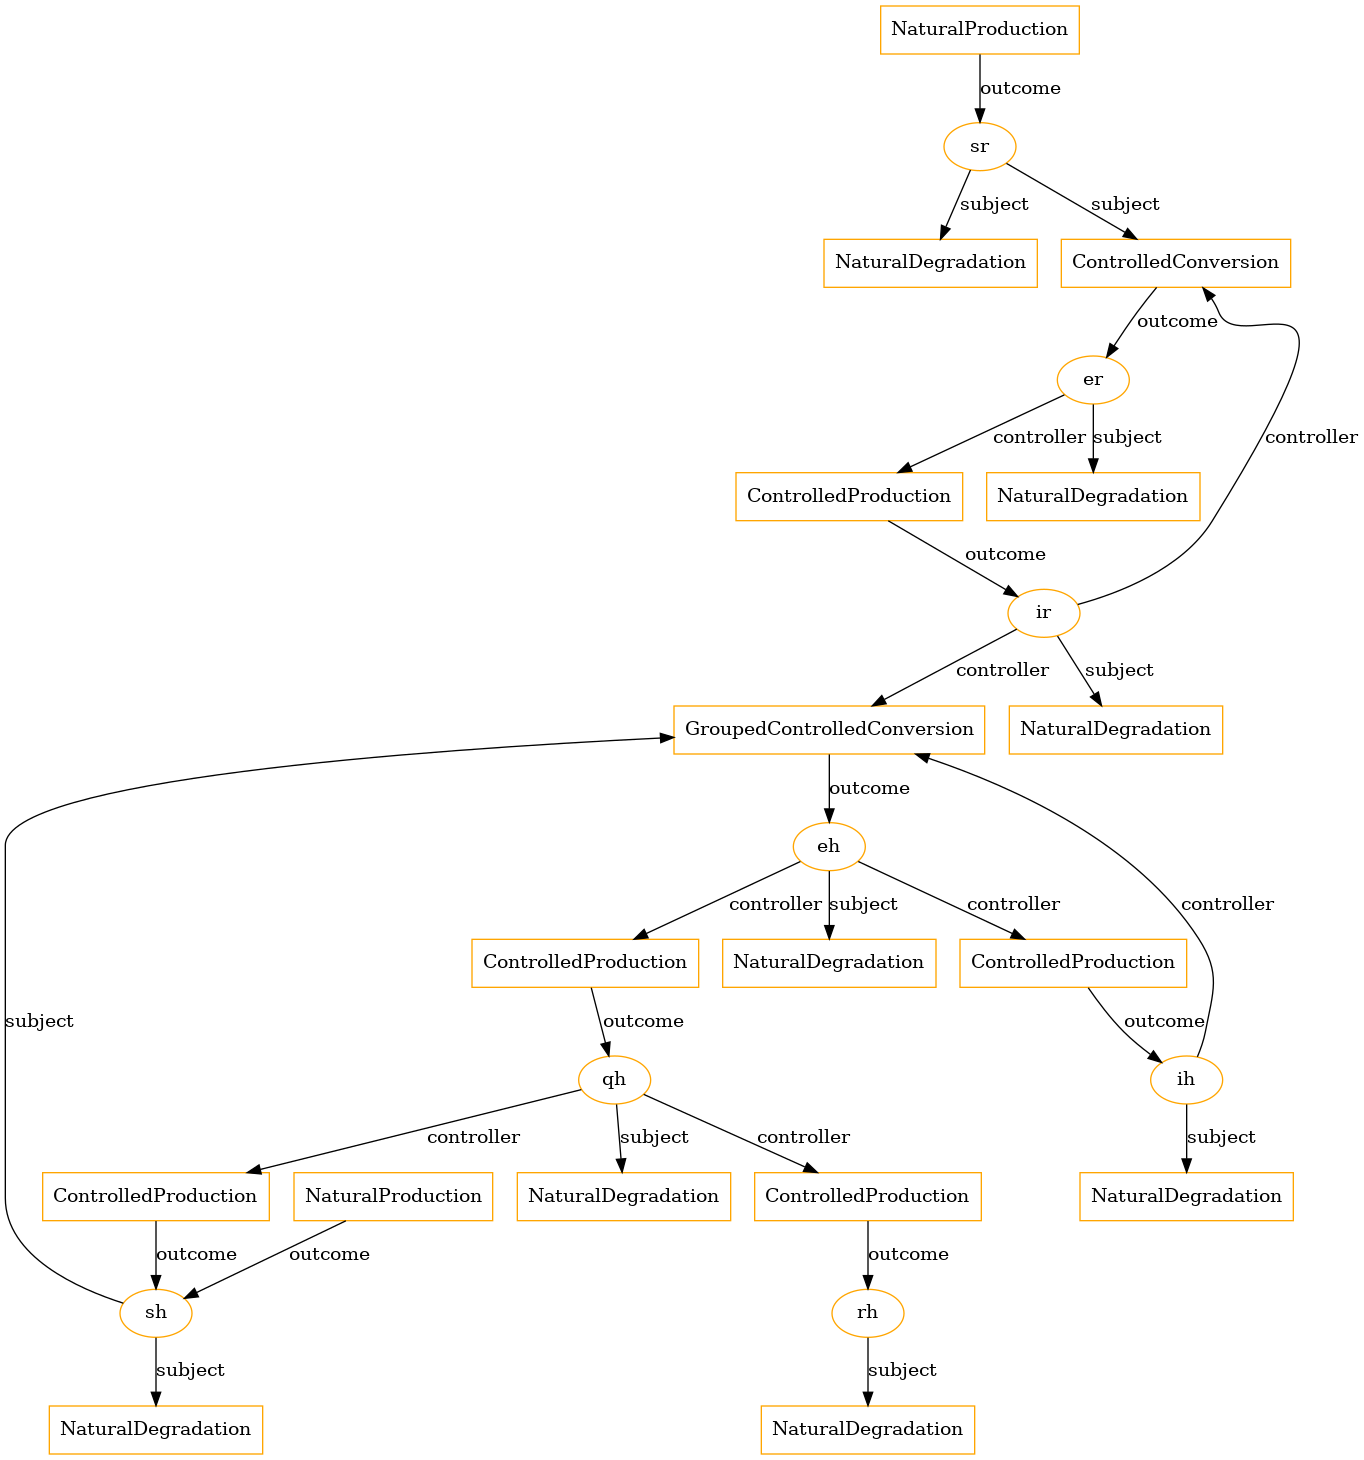

In [170]:
# Correct tm structure
correct_tm_2024_dec_epi1_modelB.draw_jupyter()

In [171]:
# December 2024 Hackathon Epi Scenario 1 Model C

# Executes straight out the box

# Structural correctness edits
# 1. Does not expand lambda terms which leads to model being less sophisticated as fewer compartments are involved the equations
# for each compartment. - Missing expansion of term


original_ode_string_2024_dec_epi_1_model_C = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
s_m, e_m, i_m, r_m = sympy.symbols("s_m e_m i_m r_m", cls=sympy.Function)
s_w, e_w, i_w, r_w = sympy.symbols("s_w e_w i_w r_w", cls=sympy.Function)

# Define the parameters
lambda_m, alpha_m, tau_m = sympy.symbols("lambda_m alpha_m tau_m")
lambda_w, alpha_w, tau_w = sympy.symbols("lambda_w alpha_w tau_w")

odes = [
    sympy.Eq(s_m(t).diff(t), - lambda_m * s_m(t)),
    sympy.Eq(e_m(t).diff(t), lambda_m * s_m(t) - alpha_m * e_m(t)),
    sympy.Eq(i_m(t).diff(t), alpha_m * e_m(t) - tau_m * i_m(t)),
    sympy.Eq(r_m(t).diff(t), tau_m * i_m(t)),
    sympy.Eq(s_w(t).diff(t), - lambda_w * s_w(t)),
    sympy.Eq(e_w(t).diff(t), lambda_w * s_w(t) - alpha_w * e_w(t)),
    sympy.Eq(i_w(t).diff(t), alpha_w * e_w(t) - tau_w * i_w(t)),
    sympy.Eq(r_w(t).diff(t), tau_w * i_w(t))
]
"""

error_free_tm_2024_dec_epi1_modelC = execute_template_model_from_sympy_odes(
    ode_str=original_ode_string_2024_dec_epi_1_model_C,
    attempt_grounding=False,
    client=client,
)

correct_ode_string_2024_dec_epi_1_model_C = """
import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
s_m, e_m, i_m, r_m = sympy.symbols("s_m e_m i_m r_m", cls=sympy.Function)
s_w, e_w, i_w, r_w = sympy.symbols("s_w e_w i_w r_w", cls=sympy.Function)

# Define the parameters
lambda_m, alpha_m, alpha_1, tau_m, beta_mm, beta_mw, N_m  = sympy.symbols("lambda_m alpha_m alpha_1 tau_m beta_mm beta_mw N_m")
lambda_w, alpha_w, alpha_2, alpha_3, tau_w, beta_ww, beta_wm, N_w  = sympy.symbols("lambda_w alpha_w alpha_2 alpha_3 tau_w beta_ww beta_wm N_w")

lambda_m = (beta_mm * i_m(t) / N_m) + (alpha_1 * beta_wm * i_w(t) / N_m)
lambda_w = (alpha_2 * beta_mw * i_m(t) / N_w) + (alpha_3 * beta_ww * i_w(t) / N_w)

odes = [
    sympy.Eq(s_m(t).diff(t), - lambda_m * s_m(t)),
    sympy.Eq(e_m(t).diff(t), lambda_m * s_m(t) - alpha_m * e_m(t)),
    sympy.Eq(i_m(t).diff(t), alpha_m * e_m(t) - tau_m * i_m(t)),
    sympy.Eq(r_m(t).diff(t), tau_m * i_m(t)),
    sympy.Eq(s_w(t).diff(t), - lambda_w * s_w(t)),
    sympy.Eq(e_w(t).diff(t), lambda_w * s_w(t) - alpha_w * e_w(t)),
    sympy.Eq(i_w(t).diff(t), alpha_w * e_w(t) - tau_w * i_w(t)),
    sympy.Eq(r_w(t).diff(t), tau_w * i_w(t))
]
"""

correct_tm_2024_dec_epi1_modelC = execute_template_model_from_sympy_odes(
    ode_str=correct_ode_string_2024_dec_epi_1_model_C,
    attempt_grounding=False,
    client=client,
)

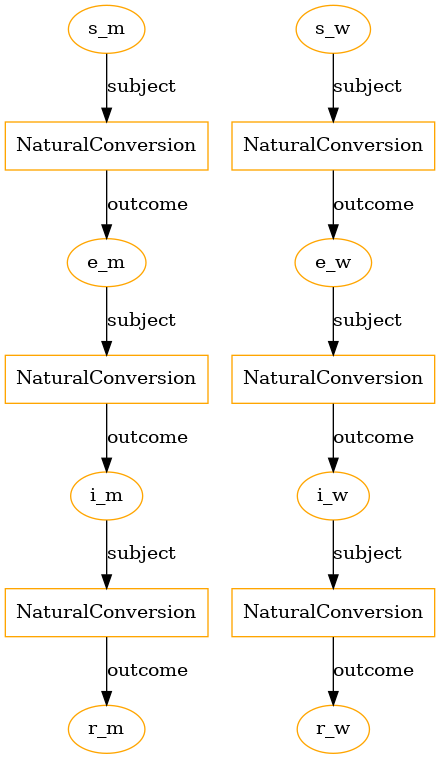

In [172]:
error_free_tm_2024_dec_epi1_modelC.draw_jupyter()

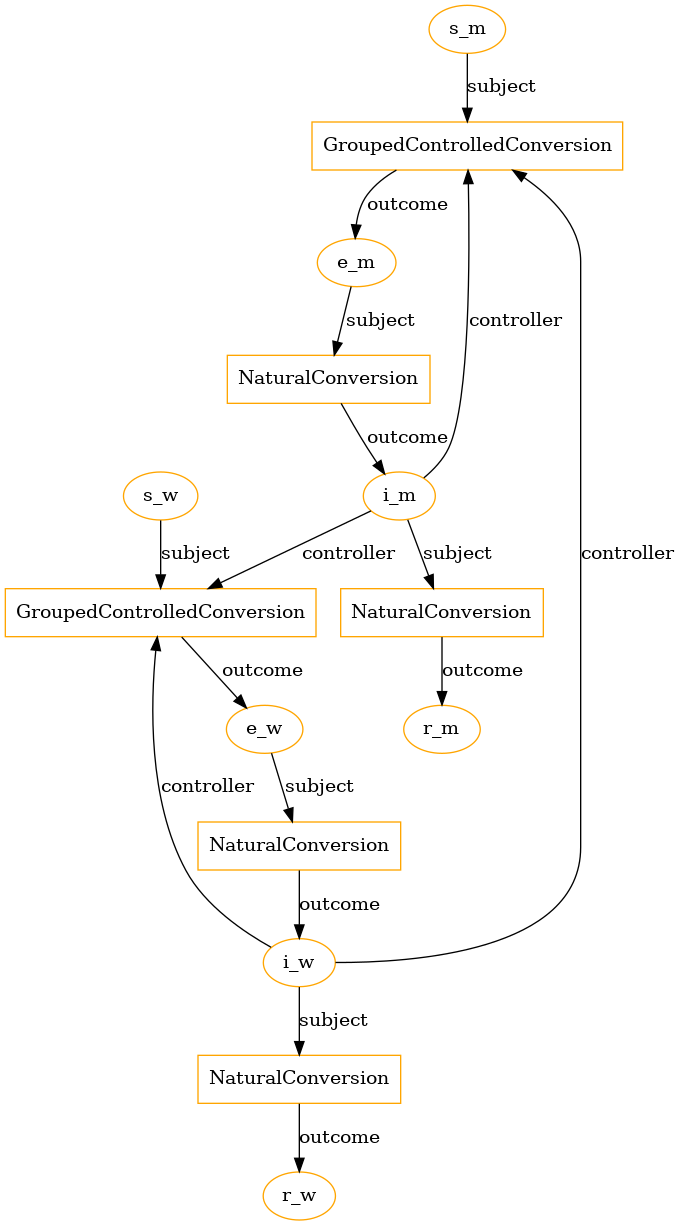

In [173]:
correct_tm_2024_dec_epi1_modelC.draw_jupyter()

In [174]:
# SAPHIRE Model from this paper published in nature: https://www.nature.com/articles/s41586-020-2554-8

# Executes straight out the box

# Smaller correctness edits
# 1. Missing divide by N for "n*P(t)" term in equation for compartment P - Missing parameter


original_saphire_str = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, P, A, I, H, R = sympy.symbols("S E P A I H R", cls=sympy.Function)

# Define the parameters
n, b, alpha, l, N, De, Dp, Di, Dq, Dh, r = sympy.symbols("n b alpha l N De Dp Di Dq Dh r")

odes = [
    sympy.Eq(S(t).diff(t), n - b * (alpha * P(t) + alpha * A(t) + l) / N * S(t) - n * S(t) / N),
    sympy.Eq(E(t).diff(t), b * (alpha * P(t) + alpha * A(t) + l) / N * S(t) - E(t) / De - n * E(t) / N),
    sympy.Eq(P(t).diff(t), E(t) / De - P(t) / Dp - n * P(t)),
    sympy.Eq(A(t).diff(t), (1 - r) * P(t) / Dp - A(t) / Di - n * A(t) / N),
    sympy.Eq(I(t).diff(t), r * P(t) / Dp - I(t) / Di - I(t) / Dq),
    sympy.Eq(H(t).diff(t), I(t) / Dq - H(t) / Dh),
    sympy.Eq(R(t).diff(t), A(t) + I(t) / Di - H(t) / Dh - n * R(t) / N)
]
"""

error_free_saphire_tm = execute_template_model_from_sympy_odes(
    ode_str=original_saphire_str, attempt_grounding=False, client=client
)

correct_saphire_str = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, P, A, I, H, R = sympy.symbols("S E P A I H R", cls=sympy.Function)

# Define the parameters
n, b, alpha, l, N, De, Dp, Di, Dq, Dh, r = sympy.symbols("n b alpha l N De Dp Di Dq Dh r")

odes = [
    sympy.Eq(S(t).diff(t), n - b * (alpha * P(t) + alpha * A(t) + l) / N * S(t) - n * S(t) / N),
    sympy.Eq(E(t).diff(t), b * (alpha * P(t) + alpha * A(t) + l) / N * S(t) - E(t) / De - n * E(t) / N),
    sympy.Eq(P(t).diff(t), E(t) / De - P(t) / Dp - n * P(t)/N),
    sympy.Eq(A(t).diff(t), (1 - r) * P(t) / Dp - A(t) / Di - n * A(t) / N),
    sympy.Eq(I(t).diff(t), r * P(t) / Dp - I(t) / Di - I(t) / Dq),
    sympy.Eq(H(t).diff(t), I(t) / Dq - H(t) / Dh),
    sympy.Eq(R(t).diff(t), A(t) + I(t) / Di - H(t) / Dh - n * R(t) / N)
]
"""

correct_saphire_tm = execute_template_model_from_sympy_odes(
    ode_str=correct_saphire_str, attempt_grounding=False, client=client
)

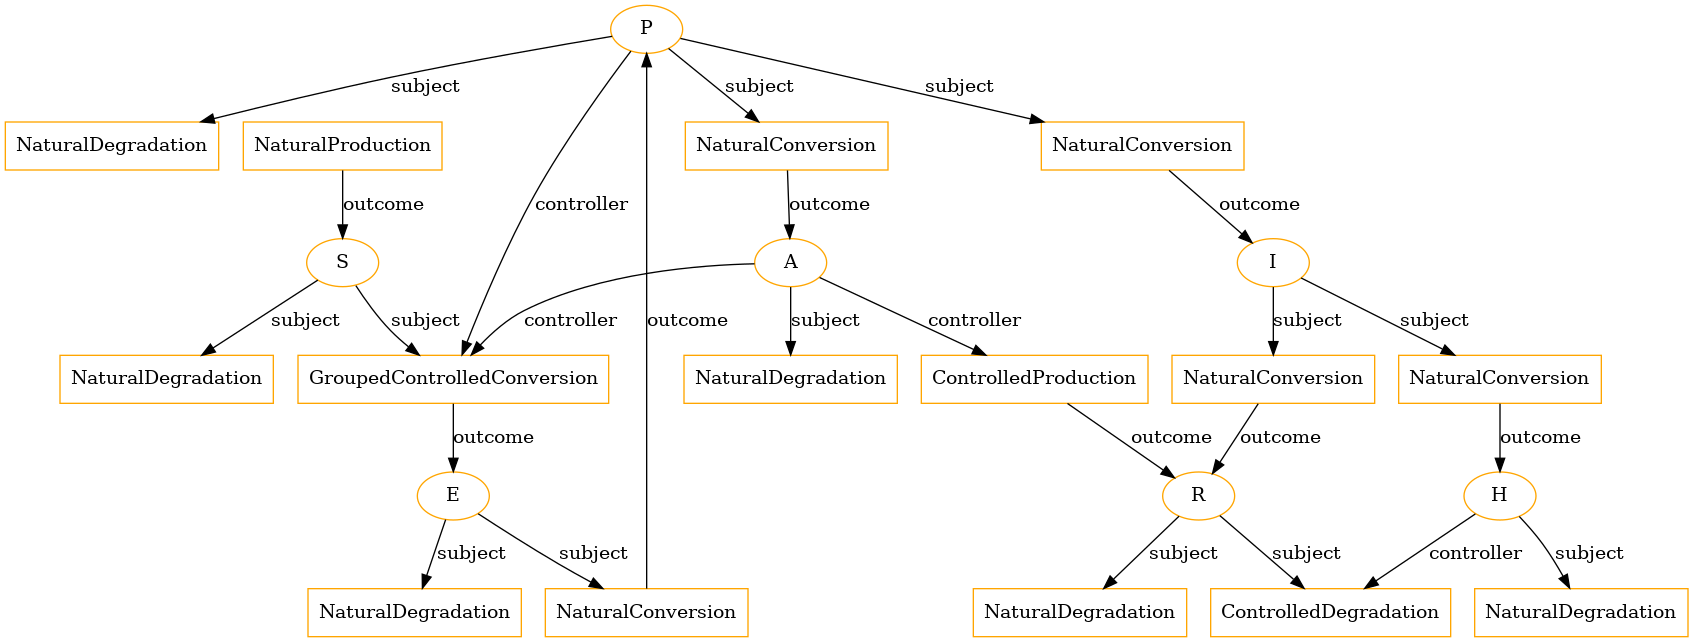

In [175]:
correct_saphire_tm.draw_jupyter()

# Models and edit taxonomy

## Model 955
- **Correctness**
  - 1 parameter duplication edit *(small)*  

## Model 956
- **Correctness**
  - 1 parameter-to-compartment conflation edit *(structural)*  

## Model 957
- **No edits**  

## Model 958
- **Execution**
  - 3 undefined parameter edits  
  - 1 erroneous usage of a nonexistent parameter  
- **Correctness**
  - 3 missing parameter edits *(small)*  
  - 1 missing term involving compartments edit *(structural)*  

## Model 960
- **Execution**
  - 1 erroneous usage of a nonexistent parameter  
  - 2 undefined parameter edits  
- **Correctness**
  - 1 missing parameter edit *(small)*  
  - 6 parameter conflation edits *(small)*  

## Model 962
- **Correctness**
  - 1 time-dependence error edit *(structural)*  

## December 2024 hackathon – Epi scenario 1 model A
- **Execution**
  - 10 undefined parameter edits
  - 1 inconsistent compartment naming edit 
- **Correctness**
  -  12 parameter conflation edits *(small)*  
  -  4 missing parameter edits *(small)*  
  -  1 incorrect compartment naming edit *(small)*
  -  4 incorrect system dyanmics edits *(structural)*
  -  1 removal of invalid equations *(structural)*
  -  3 missing term involving compartments edits *(structural)*

## December 2024 hackathon – Epi scenario 1 model B
- **Execution**
  - 1 undefined parameter edit  
  - 1 missing compartment definition edit  
- **Correctness**
  - 7 parameter conflation edits *(small)*  
  - 2 missing parameter edits *(small)*  
  - 2 missing term involving compartments edits *(structural)*  

## December 2024 hackathon – epi scenario 1 model C
- **Correctness**
  - 1 does not expand term involving a compartment edit *(structural)*  


## SAPHIRE Model
- **Correctness**
  - 1 missing parameter edit *(small)*  

---


# Summary of error types

## **Execution errors**
- **Undefined parameter edits**: 16  
- **Erroneous usage of a nonexistent parameter**: 2  
- **Missing compartment definition**: 1
- **Inconsistent compartment naming edits**: 1


## **Correctness errors**
- Small
    - **Parameter duplication**: 1  
    - **Parameter conflation**: 25 
    - **Missing parameter**: 11
    - **Incorrect compartment naming edit**: 1

- Structural 
    - **Missing term involving compartments**: 6  
    - **Parameter-to-compartment conflation**: 1 
    - **Does not expand term involving a compartment**: 1 
    - **Time-dependence error**: 1
    - **Incorrect system dyanmics**: 4
    - **Removal of invalid equations**: 1

In [201]:
import pandas as pd


# To benchmark additional models, add the model to the model_map dictionary below where the key is the 
# index of the model in the errors list (incrementing by 1) and the value is the model name. 
# A newly added model to the dictionary now would have a key of 10
model_map = {
    0: "BIOMD0000000955",
    1: "BIOMD0000000956",
    2: "BIOMD0000000957",
    3: "BIOMD0000000958",
    4: "BIOMD0000000960",
    5: "BIOMD0000000962",
    6: "Hackathon Model A",
    7: "Hackathon Model B",
    8: "Hackathon Model C",
    9: "SAPHIRE",
}

model_list = model_map.values()

# Then add the respective number of errors that are attributed to the newly added model as a new element in each of the lists below
undefined_parameter_errors = [0, 0, 0, 3, 2, 0, 10, 1, 0, 0]
nonexistent_parameter_errors = [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
inconsistent_compartment_naming = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
incorrect_compartment_name = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
parameter_duplication = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
parameter_conflation = [0, 0, 0, 0, 6, 0, 12, 7, 0, 0]
missing_parameters = [0, 0, 0, 3, 1, 0, 4, 2, 0, 1]
missing_compartment_term = [0, 0, 0, 1, 0, 0, 3, 2, 0, 0]
incorrect_system_dyanmics = [0, 0, 0, 0, 0, 0, 4, 0, 0, 0]
invalid_equation_removal = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
parameter_compartment_conflation = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
time_dependence_error = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
non_expansion_term = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


error_distribution = defaultdict(dict)

list_variables_dict = {
    ("Undefined parameter error", "Execution"): undefined_parameter_errors,
    ("Nonexistent parameter error", "Execution"): nonexistent_parameter_errors,
    (
        "Inconsistent compartment naming error",
        "Execution",
    ): inconsistent_compartment_naming,
    (
        "Incorrect compartment name error",
        "Correctness/small",
    ): incorrect_compartment_name,
    (
        "Parameter duplication error",
        "Correctness/small",
    ): parameter_duplication,
    ("Parameter conflation error", "Correctness/small"): parameter_conflation,
    ("Missing parameter error", "Correctness/small"): missing_parameters,
    (
        "Missing compartment term error",
        "Correctness/structural",
    ): missing_compartment_term,
    (
        "Incorrect system dynamics error",
        "Correctness/structural",
    ): incorrect_system_dyanmics,
    (
        "Invalid equation removal",
        "Correctness/structural",
    ): invalid_equation_removal,
    (
        "Parameter-to-compartment conflation error",
        "Correctness/structural",
    ): parameter_compartment_conflation,
    (
        "Time dependence error",
        "Correctness/structural",
    ): time_dependence_error,
    (
        "Non-expansion of term error",
        "Correctness/structural",
    ): non_expansion_term,
}


data = {
    "Model": model_list,
    "Undefined parameter": undefined_parameter_errors,
    "Usage of nonexistent parameter": nonexistent_parameter_errors,
    "Missing compartment definition": missing_compartment_term,
    "Inconsistent compartment names": inconsistent_compartment_naming,
    "Incorrect compartment name": incorrect_compartment_name,
    "Parameter duplication": parameter_duplication,
    "Parameter conflation": parameter_conflation,
    "Missing parameter": missing_parameters,
    "Missing term (compartment)": missing_compartment_term,
    "Incorrect system dynamics": incorrect_system_dyanmics,
    "Invalid equation removal": invalid_equation_removal,
    "Parameter-to-compartment conflation": parameter_compartment_conflation,
    "Time-dependence error": time_dependence_error,
    "Does not expand term": non_expansion_term,
}

df = pd.DataFrame(data)


df

,Model,Undefined parameter,Usage of nonexistent parameter,Missing compartment definition,Inconsistent compartment names,Incorrect compartment name,Parameter duplication,Parameter conflation,Missing parameter,Missing term (compartment),Incorrect system dynamics,Invalid equation removal,Parameter-to-compartment conflation,Time-dependence error,Does not expand term
0,BIOMD0000000955,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,BIOMD0000000956,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,BIOMD0000000957,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,BIOMD0000000958,3,1,1,0,0,0,0,3,1,0,0,0,0,0
4,BIOMD0000000960,2,1,0,0,0,0,6,1,0,0,0,0,0,0
5,BIOMD0000000962,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,Hackathon Model A,10,0,3,1,1,0,12,4,3,4,1,0,0,0
7,Hackathon Model B,1,0,2,0,0,0,7,2,2,0,0,0,0,0
8,Hackathon Model C,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,SAPHIRE,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Metrics

In [208]:
num_models = len(model_list)
all_models = set(model_list)
execution_error_models = set()
correctness_error_small_models = set()
correctness_error_structural_models = set()
model_error_types = defaultdict(set)

for tup, error_list in list_variables_dict.items():
    error_name = tup[0]
    error_type = tup[1]

    error_type_total = sum(error_list) 
    print(
        f"On average, there are {round(error_type_total/num_models,3)} {error_name}s per model ingested in this benchmark."
    )
    if error_type == "Execution":
        non_zero_models_index = [
            index for index, value in enumerate(error_list) if value != 0
        ]
        for index in non_zero_models_index:
            model = model_map.get(index)
            error_distribution[model][error_name] = error_list[index]/error_type_total
            
            
            execution_error_models.add(model)
            model_error_types[error_name].add(model)
    elif error_type == "Correctness/small":
        non_zero_models_index = [
            index for index, value in enumerate(error_list) if value != 0
        ]
        for index in non_zero_models_index:
            model = model_map.get(index)
            error_distribution[model][error_name] = error_list[index]/error_type_total

            correctness_error_small_models.add(model)
            model_error_types[error_name].add(model)

    elif error_type == "Correctness/structural":
        non_zero_models_index = [
            index for index, value in enumerate(error_list) if value != 0
        ]
        for index in non_zero_models_index:
            model = model_map.get(index)
            error_distribution[model][error_name] = error_list[index]/error_type_total

            
            correctness_error_structural_models.add(model)
            model_error_types[error_name].add(model)


execution_error_free_models = all_models - execution_error_models
no_error_models = (
    all_models
    - execution_error_models
    - correctness_error_small_models
    - correctness_error_structural_models
)

On average, there are 1.6 Undefined parameter errors per model ingested in this benchmark.
On average, there are 0.2 Nonexistent parameter errors per model ingested in this benchmark.
On average, there are 0.1 Inconsistent compartment naming errors per model ingested in this benchmark.
On average, there are 0.1 Incorrect compartment name errors per model ingested in this benchmark.
On average, there are 0.1 Parameter duplication errors per model ingested in this benchmark.
On average, there are 2.5 Parameter conflation errors per model ingested in this benchmark.
On average, there are 1.1 Missing parameter errors per model ingested in this benchmark.
On average, there are 0.6 Missing compartment term errors per model ingested in this benchmark.
On average, there are 0.4 Incorrect system dynamics errors per model ingested in this benchmark.
On average, there are 0.1 Invalid equation removals per model ingested in this benchmark.
On average, there are 0.1 Parameter-to-compartment conflat

In [178]:
for error, model_set in model_error_types.items():
    print(
        f"{len(model_set)/len(model_list) * 100}% of the models have an {error}. \nThese models are {model_set}."
    )

40.0% of the models have an Undefined parameter error. 
These models are {'Hackathon Model A', 'BIOMD0000000960', 'Hackathon Model B', 'BIOMD0000000958'}.
20.0% of the models have an Nonexistent parameter error. 
These models are {'BIOMD0000000960', 'BIOMD0000000958'}.
10.0% of the models have an Inconsistent compartment naming error. 
These models are {'Hackathon Model A'}.
10.0% of the models have an Incorrect compartment name error. 
These models are {'Hackathon Model A'}.
10.0% of the models have an Parameter duplication error. 
These models are {'BIOMD0000000955'}.
30.0% of the models have an Parameter conflation error. 
These models are {'Hackathon Model A', 'BIOMD0000000960', 'Hackathon Model B'}.
50.0% of the models have an Missing parameter error. 
These models are {'Hackathon Model A', 'Hackathon Model B', 'BIOMD0000000960', 'SAPHIRE', 'BIOMD0000000958'}.
30.0% of the models have an Missing compartment term error. 
These models are {'Hackathon Model A', 'Hackathon Model B', '

In [205]:
for model, error_dict in error_distribution.items():
    for error_type, error_weight in error_dict.items():
        print(f"Model {model} accounted for {round(error_weight,3)*100} % of {error_type}s")

Model BIOMD0000000958 accounted for 18.8 % of Undefined parameter errors
Model BIOMD0000000958 accounted for 50.0 % of Nonexistent parameter errors
Model BIOMD0000000958 accounted for 27.3 % of Missing parameter errors
Model BIOMD0000000958 accounted for 16.7 % of Missing compartment term errors
Model BIOMD0000000960 accounted for 12.5 % of Undefined parameter errors
Model BIOMD0000000960 accounted for 50.0 % of Nonexistent parameter errors
Model BIOMD0000000960 accounted for 24.0 % of Parameter conflation errors
Model BIOMD0000000960 accounted for 9.1 % of Missing parameter errors
Model Hackathon Model A accounted for 62.5 % of Undefined parameter errors
Model Hackathon Model A accounted for 100.0 % of Inconsistent compartment naming errors
Model Hackathon Model A accounted for 100.0 % of Incorrect compartment name errors
Model Hackathon Model A accounted for 48.0 % of Parameter conflation errors
Model Hackathon Model A accounted for 36.4 % of Missing parameter errors
Model Hackathon 

In [179]:
if len(no_error_models) == 0:
    print(
        "There are no models that did not require any manual intervention to generate a semantically correct corresponding MIRA template model"
    )
elif len(no_error_models) == 1:
    print(
        f"There was 1 model that did not require any manual intervention to generate a semantically correct corresponding MIRA template model. \nThat model is {no_error_models}."
    )
else:
    print(
        f"The {len(no_error_models)} models that were able to generate semantically corresponding MIRA template models were \n{no_error_models}"
    )

There was 1 model that did not require any manual intervention to generate a semantically correct corresponding MIRA template model. 
That model is {'BIOMD0000000957'}.


In [180]:
if len(execuction_error_models) == 0:
    print(
        "There are no models that required manual intervention to generate a corresponding MIRA template model."
    )
elif len(execuction_error_models) == 1:
    print(
        f"There was 1 model that required manual intervention to generate a corresponding MIRA template model. \nThat model is {execuction_error_models}."
    )
else:
    print(
        f"The {len(execuction_error_models)} models that were not able to generate corresponding MIRA template models without manual intervention were \n{execuction_error_models}."
    )

The 4 models that were not able to generate corresponding MIRA template models without manual intervention were 
{'Hackathon Model A', 'BIOMD0000000960', 'Hackathon Model B', 'BIOMD0000000958'}.


In [181]:
if len(correctness_error_small_models) == 0:
    print(
        "There are no models that required manual intervention to address a small issue to create a semantically correct MIRA template model."
    )
elif len(correctness_error_small_models) == 1:
    print(
        f"There was 1 model that required a small manual correction to create a semantically correct MIRA template model. The correction did not affect the structure of the model. That model is \n{correctness_error_small_models}."
    )
else:
    print(
        f"The {len(correctness_error_small_models)} models that required small manual corrections to create semantically correct MIRA template models are \n{correctness_error_small_models}. \nThese corrections did not affect the structure of the models."
    )

The 6 models that required small manual corrections to create semantically correct MIRA template models are 
{'Hackathon Model A', 'Hackathon Model B', 'BIOMD0000000955', 'BIOMD0000000960', 'SAPHIRE', 'BIOMD0000000958'}. 
These corrections did not affect the structure of the models.


In [182]:
if len(correctness_error_structural_models) == 0:
    print(
        "There are no models that required manual intervention to address a structural issue to create a semantically correct MIRA template model."
    )
elif len(correctness_error_structural_models) == 1:
    print(
        f"There was 1 model that required manual intervention to create a semantically correct MIRA template model. The correction involved changes to the structure of the model. That model is \n{correctness_error_structural_models}."
    )
else:
    print(
        f"The {len(correctness_error_structural_models)} models that required manual intervention to create semantically correct MIRA template models are \n{correctness_error_structural_models}. \nThese corrections involved changes to the structure of the models."
    )

The 6 models that required manual intervention to create semantically correct MIRA template models are 
{'Hackathon Model C', 'BIOMD0000000956', 'Hackathon Model A', 'Hackathon Model B', 'BIOMD0000000962', 'BIOMD0000000958'}. 
These corrections involved changes to the structure of the models.


# Notes
Overall outside of December 2024 hackathon – Epi scenario 1 model A and December 2024 hackathon – Epi scenario 1 model B, each model only needed 10 or fewer edits to obtain the correct model structure. Besides December 2024 hackathon – Epi scenario 1 model A, the process of editing the ODEs for each model was not tedious and relatively straight forward to do. 

The average number of parameter conflation and undefined parameter errors are inflated due to the numerous errors in Hackathon models
A and B. 